In [1]:
import time
from collections import Counter
from scipy.io import loadmat
from scipy import signal
from itertools import groupby
import matplotlib
from operator import itemgetter
import os
import seaborn as sns
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import sys
sys.path.insert(0, r'..\tools')
from scan import scan_sort
from EM_detection import find_peak
from zscore import zscore
from smooth import smooth,ins_smooth,de_sampling

['F:\\jcy\\EEG_program\\ssVEP_mice\\SSVEP20240106_Blind\\MICE1\\SESSION1', 'F:\\jcy\\EEG_program\\ssVEP_mice\\SSVEP20240106_Blind\\MICE1\\SESSION2', 'F:\\jcy\\EEG_program\\ssVEP_mice\\SSVEP20240106_Blind\\MICE1\\SESSION3', 'F:\\jcy\\EEG_program\\ssVEP_mice\\SSVEP20240106_Blind\\MICE2\\SESSION1', 'F:\\jcy\\EEG_program\\ssVEP_mice\\SSVEP20240106_Blind\\MICE2\\SESSION2', 'F:\\jcy\\EEG_program\\ssVEP_mice\\SSVEP20240106_Blind\\MICE3\\SESSION1', 'F:\\jcy\\EEG_program\\ssVEP_mice\\SSVEP20240106_Blind\\MICE3\\SESSION2']


In [2]:
'''
时间轴进行normarlize，只在对应的位置插入一个点；
    input：data；
    window：希望最终得到的长度；
'''
def normalized_time(data,time_window):
    plt.subplots(1,2,figsize=(6,2))
    index_data = np.where(np.array(data) > 0.5)[0]
    per_inde = index_data / len(data)
    ins = np.zeros(time_window)
    ins[np.ceil(per_inde * len(ins)).astype(int)] = 1

    len_normalized=np.where(np.array(ins)>0.5)[0]
    plt.subplot(121);plt.plot(ins);plt.scatter(len_normalized,ins[len_normalized],c='r')
    plt.subplot(122);plt.plot(data)
    # print(f'原始数据满足要求的数量：{len(index_data)},normarlized后的数量： {len(len_normalized)}')
    return ins

In [3]:
'''
    raster_data is input dataset;
    n is the row number of input raster_data
    out_path is the directory of exported file
    dataset_type=list
    defualt: n=6
'''

###参考：https://matplotlib.org/stable/gallery/lines_bars_and_markers/eventplot_demo.html#sphx-glr-gallery-lines-bars-and-markers-eventplot-demo-py
def raster_plot(raster_data,n,out_path:Path):
    matplotlib.rcParams['font.size'] = 8.0

    out_path=Path(out_path)

    data1 =raster_data

    # set different colors for each set of positions
    colors1 = ['C{}'.format(i) for i in range(n)]

    # set different line properties for each set of positions
    # note that some overlap
    lineoffsets1 = [i for i in range(n)]
    linelengths1 = [0.5]*n

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

    # create a horizontal plot
    axs[2]=axs[0].twinx()
    axs[0].eventplot(data1, colors=colors1, lineoffsets=lineoffsets1, linelengths=linelengths1)

    # create a vertical plot
    flat_em_raster=[j for i in data1 for j in i]
    axs[1].hist(flat_em_raster,bins=40,histtype='stepfilled',facecolor='dodgerblue', alpha=0.5)
    # axs[1].eventplot(data1, colors=colors1, lineoffsets=lineoffsets1, linelengths=linelengths1, orientation='vertical')

    axs[2].hist(flat_em_raster, bins=40, histtype='step', stacked=True, fill=False)
    axs[2].set_title('stack step (unfilled)')
    if is_save=='yes':
        plt.savefig(str(newPath) + '\\' + 'em_raster.pdf', bbox_inches='tight')

    plt.show()

In [4]:
'''
input:
    stage:list of stage;
    EM_path: data path:
output:
    EM_fre:eye movements frequency in each stage;
    EM_index:the index of stage which possess the positive eye movements;
'''
def find_peak(em_data,P_threshold,N_threshold):
    threshold = 20     ###连续上升或者下降的数据点数
    start,end= threshold,len(em_data)-threshold
    # print(P_threshold,N_threshold)
    scatter_x = []
    for i in range(start,end):
        before = sorted(em_data[i - threshold:i])
        after = sorted(em_data[i + 1:i + threshold + 1])
        if em_data[i] > before[-1] and em_data[i] > after[- 1]:   ##set集合
            scatter_x.append(i)
        if em_data[i] < before[0] and em_data[i] < after[0]:
            scatter_x.append(i)

    ###满足条件的峰数
    all_spike=[j for j in scatter_x if em_data[j]>=P_threshold or em_data[j]<=N_threshold]
    peak_index=[0]*len(em_data)
    for i in all_spike:
        peak_index[i]=1

    return len(all_spike),peak_index


def em_extract(stage, EM, file):
    print('---计算每个epoch的眼动频率---')
    em=smooth(EM,11)

    em_list=np.array(em).reshape((-1,2000))
    em_wake = em_list[stage ==0].reshape(-1)
    w1, w2 = np.mean(em_wake), np.std(em_wake)

    em_sleep = em_list[stage !=0].reshape(-1)
    s1, s2 = np.mean(em_sleep), np.std(em_sleep)
    k = 1.96
    stage_mean = {'0':w1, '5':s1,'10':s1}
    stage_std = {'0':w2, '5':s2,'10':s2}
    print(f'mice{file}em_mean:{stage_mean}\nem_std:{stage_std}')
    em_fre,em_index=[],[]
    for n,epoch_n in enumerate(stage):
        em_epoch=em_list[n]
        P_threshold = stage_mean[str(epoch_n)] + k * stage_std[str(epoch_n)]
        N_threshold = stage_mean[str(epoch_n)] - k * stage_std[str(epoch_n)]

        spike,peak_index = find_peak(em_epoch, P_threshold, N_threshold)
        em_fre.append(spike)
        em_index.extend(peak_index)

    em_peak_x= [i[0] for i in enumerate(em_index) if i[1]==1]
    plt.figure(figsize=(12,3))
    plt.plot(em,c='black',label=file)
    plt.hlines(w1-k*w2,0,len(em),colors='g',label='wake_n');plt.hlines(s1-k*s2,0,len(em),colors='b',label='sleep_n')
    plt.hlines(w1+k*w2,0,len(em),colors='g');plt.hlines(s1+k*s2,0,len(em),colors='b')
    plt.scatter(em_peak_x,np.array(em)[em_peak_x],c='r')
    plt.legend()
    plt.show()

    pd.DataFrame(em_fre,columns=['em_fre']).to_csv(os.path.dirname(newPath)+f'\\em_fre{file}',index=None)
    em_index=np.array(em_index).reshape(-1,1)
    pd.DataFrame(em_index,columns=['em_index']).to_csv(os.path.dirname(newPath)+f'\\em_index{file}',index=None)
    # print(file,len(em_fre),em_fre)
    return

In [15]:
###查找满足REM-off或则t_pREM转变的marker点
def fiber_mice(i):
    Ca,Sleep,EM=i
    file=str(Ca[-15:])

    Ch488=pd.read_table(Ca, sep=',').Ch488.astype(float).tolist()
    Ch408=pd.read_table(Ca, sep=',').Ch408.astype(float).tolist()
    Ch488 = zscore(Ch488,Ch488)   ###baseline的位置   int(len(response)*0.25)
    Ch408= zscore(Ch408, Ch408)
    Ch488=signal.detrend(Ch488, axis=0, type='linear', bp=0, overwrite_data=False)
    Ch408=signal.detrend(Ch408, axis=0, type='linear', bp=0, overwrite_data=False)

    plt.figure(figsize=(9,3),dpi=300)
    plt.plot(range(len(Ch488)),Ch488,lw=1,c='black');plt.plot(range(len(Ch488)),Ch488,lw=1,c='red');plt.show()
    ###read the stage and em data
    Stage=pd.read_table(Sleep,skiprows=18, sep='\t').Stage.astype(str)
    Stage=Stage.replace({'W':0,'NR':5,'R':10})


    em=pd.read_table(EM,sep=',').EM.values

    length=min(len(Ch488)//400,len(Stage))
    Stage=Stage[:length]
    EM=em[:length*2000]
    ##extracting eye movements
    em_extract(Stage,EM,file)  ###第一次需要运行其后都不需要运行，直接读取即可

    Ch488=Ch488[:length*400]
    Ca_list=Ch488.reshape((-1,400))

    episodes= {'0':[],'5':[],'10':[]}
    wake_index=[x[0] for x in enumerate(Stage) if x[1]==0]
    nrem_index=[x[0] for x in enumerate(Stage) if x[1]==5]
    rem_index=[x[0] for x in enumerate(Stage) if x[1]==10]

    # print(f"W_index:{wake_index}")
    for k, g in groupby(enumerate(wake_index),lambda x:x[0]-x[1]):
        group=list(map(itemgetter(1), g))
        episodes['0'].append((group[0], group[-1]+1))
    for k, g in groupby(enumerate(nrem_index),lambda x:x[0]-x[1]):
        group=list(map(itemgetter(1), g))
        episodes['5'].append((group[0], group[-1]+1))
    for k, g in groupby(enumerate(rem_index),lambda x:x[0]-x[1]):
        group=list(map(itemgetter(1), g))
        episodes['10'].append((group[0], group[-1]+1))


    ###计算状态转变的次数
    for start, end in episodes['10'][:-1]:    ###不同转变状态需修改
        if Stage[end]==10:                  ###不同转变状态需修改
            trans_number.append(end-start)
    print(f'REM episode持续时间：{trans_number}')

    em_fre=pd.read_csv(os.path.dirname(newPath)+f'\\em_fre{file}',sep=',').em_fre.values
    em_fre=np.array(em_fre)

    em_index=pd.read_csv(os.path.dirname(newPath)+f'\\em_index{file}',sep=',').em_index.values
    em_index_list=np.array(em_index).reshape((-1,2000))

    valid_episode=0
    Ca_trial,em_trial=[],[]
    ###分析特定状态转变期间钙信号和眼动
    for start, end in episodes['10'][:-1]:    ###不同转变状态需修改

        idx =[idx_i for idx_i in np.arange(start, end)]
        # print(np.array(Stage)[idx])
        epoch_n=[]
        ###转变后无眼动
        for num in [idx_i for idx_i in np.arange(end, end+len(idx))]:        #  NREM-tonicREM需要更改np.arange(end, end+len(idx),1):
            if sum(em_index_list[num])!=0:
                epoch_n.append(1)
            else:
                epoch_n.append(0)
        ###转变前无眼动
        # for num in idx:        #  NREM-tonicREM需要更改np.arange(end, end+len(idx),1):
        #     if sum(em_index_list[num])!=0:
        #         epoch_n.append(1)
        #     else:
        #         epoch_n.append(0)

        if sum(epoch_n)>=0 and 2<=len(idx)<=max_epoch and Stage[end]==0:    ###不同转变状态需修改,tonicREM状态需要增加条件sum(epoch_n)<=0 and
            valid_episode+=1
            normalized_time_len=max_epoch*2*2000
            ###nomarlize time in em index
            em_index_episode_i =em_index_list[start:end+len(idx)].flatten()
            # _,ins_em=ins_smooth(range(len(em_index_episode_i)),em_index_episode_i,normalized_time_len)
            ins_em=normalized_time(em_index_episode_i,normalized_time_len)

            ###nomarlize time in cell activity across transition
            stage_data = Ca_list[start:end+len(idx)].flatten()
            _,ins_ca=ins_smooth(range(len(stage_data)),stage_data,normalized_time_len)

            em_trial.append(ins_em)
            Ca_trial.append(ins_ca)

            all_cell['em'].append(ins_em)
            all_cell['cell'].append(ins_ca)
            all_cell['mean_before'].append(np.mean(ins_ca[:len(ins_ca)//2]))
            all_cell['mean_after'].append(np.mean(ins_ca[len(ins_ca)//2:]))
        else:
            continue
    ###提取各个trial的反应均值
    if len(em_trial)!=0:
        mean_trial_em=np.sum(em_trial,axis=0)
        mean_Ca_em=np.mean(Ca_trial,axis=0)
        all_trial['trial_name'].append(file)
        all_trial['mean_em_before'].append(np.sum(mean_trial_em[:len(mean_trial_em)//2]))
        all_trial['mean_em_after'].append(np.sum(mean_trial_em[len(mean_trial_em)//2:]))
        all_trial['mean_Ca_before'].append(np.mean(mean_Ca_em[:len(mean_Ca_em)//2]))
        all_trial['mean_Ca_after'].append(np.mean(mean_Ca_em[len(mean_Ca_em)//2:]))
    return

('rawdata\\mice1#\\fiber1\\mice1#_1fiber.txt', 'rawdata\\mice1#\\sleep1\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice1#\\sleep1\\modify_sleeprawdata.txt')


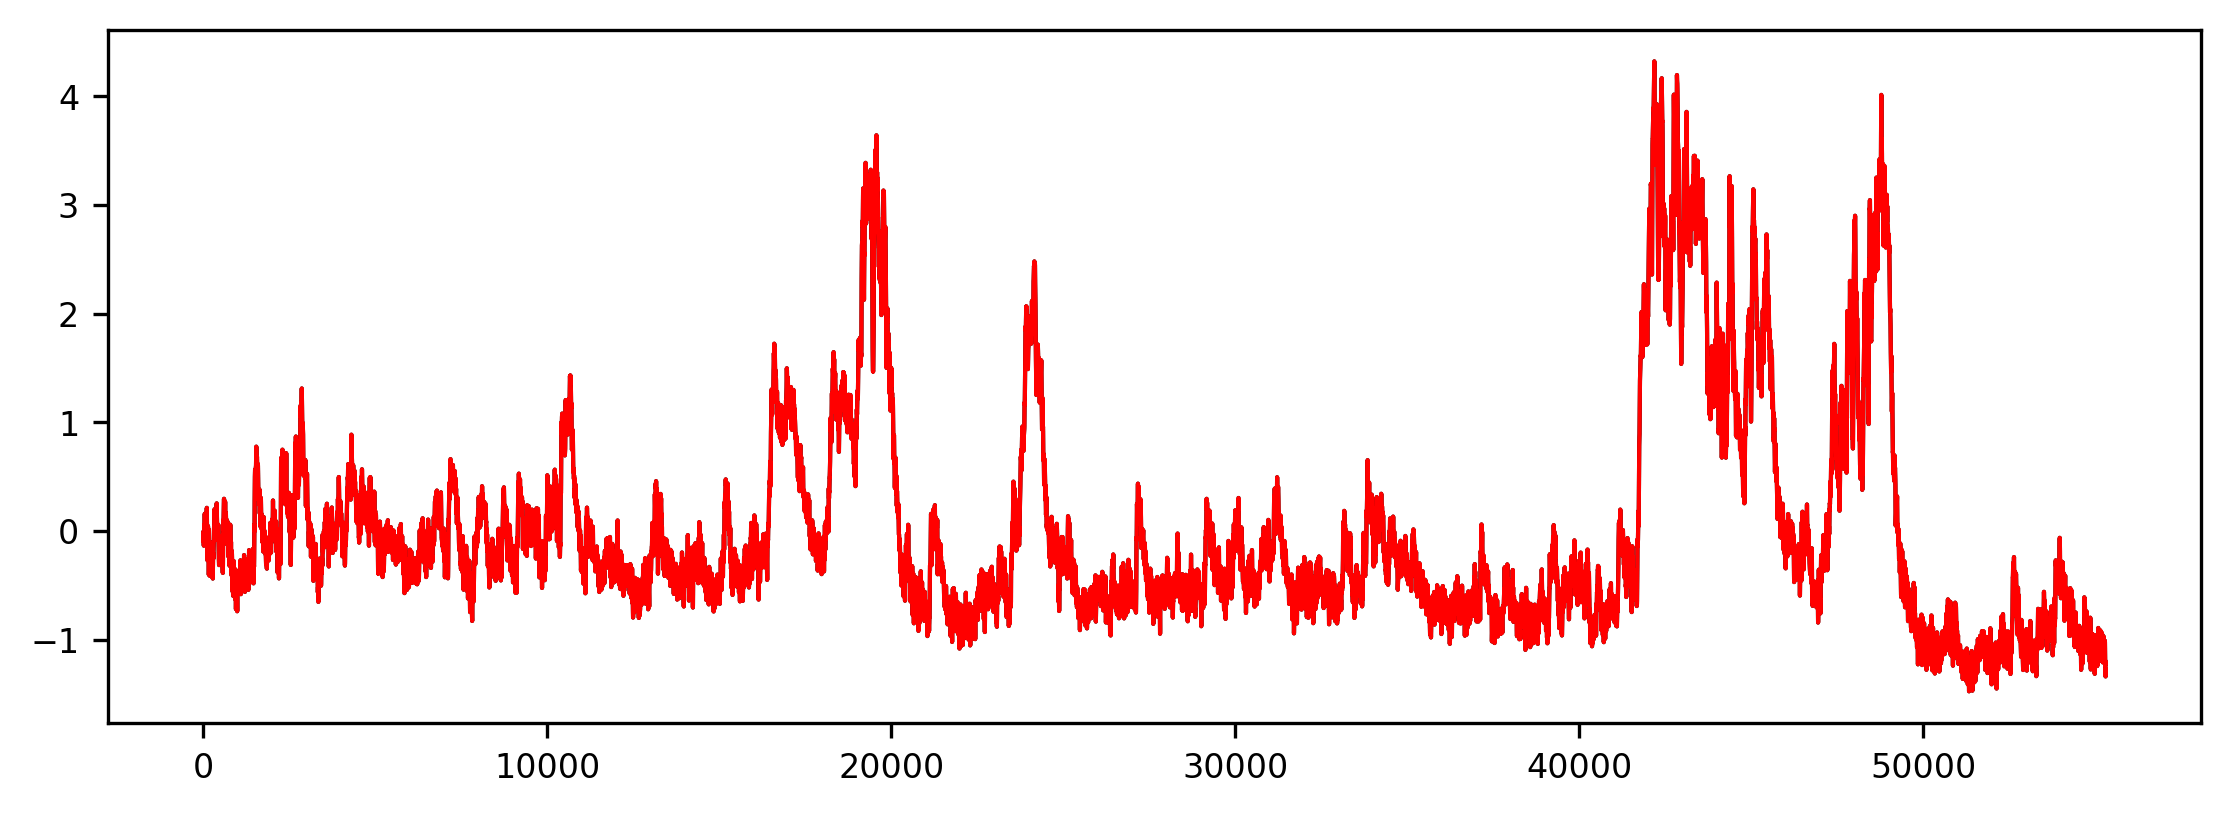

---计算每个epoch的眼动频率---
micece1#_1fiber.txtem_mean:{'0': 0.0013206417910447967, '5': -0.002222042253521129, '10': -0.002222042253521129}
em_std:{'0': 12.263987716401578, '5': 0.8853435296608184, '10': 0.8853435296608184}


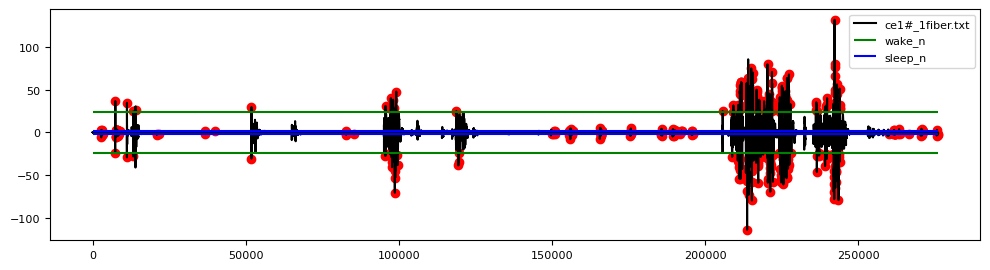

REM episode持续时间：[]
('rawdata\\mice1#\\fiber2\\mice1#_2fiber.txt', 'rawdata\\mice1#\\sleep2\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice1#\\sleep2\\modify_sleeprawdata.txt')


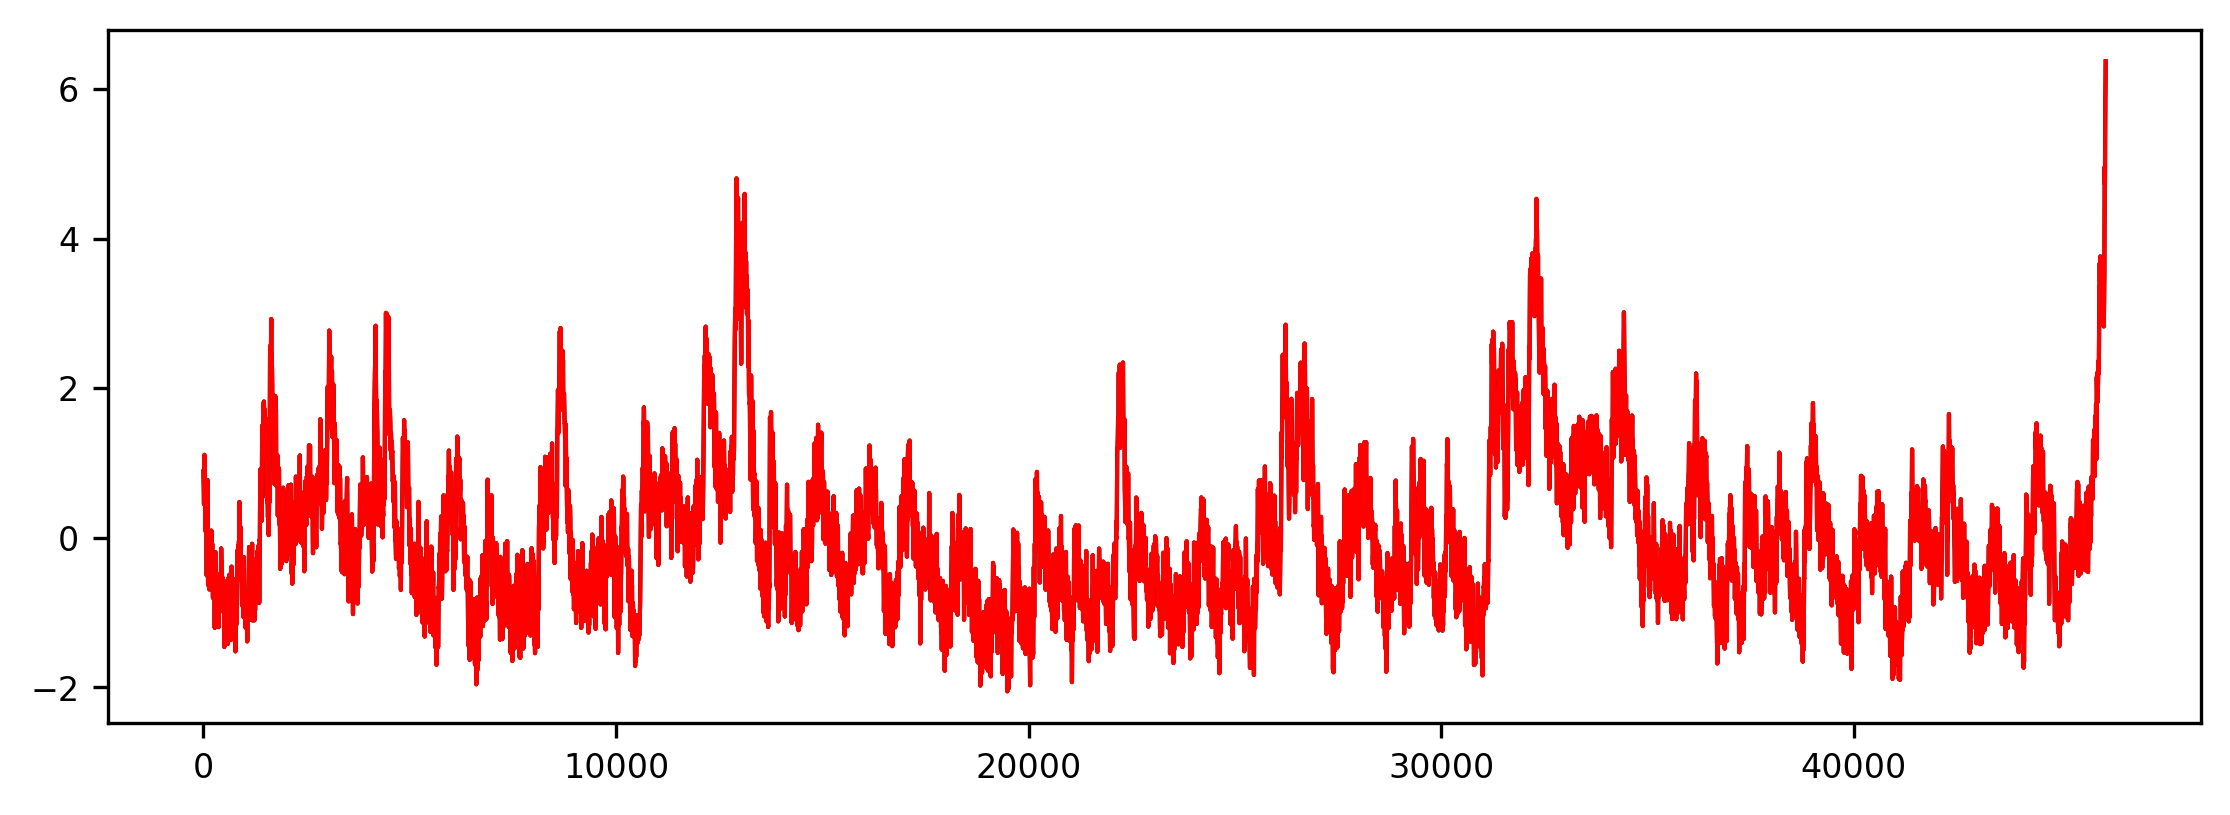

---计算每个epoch的眼动频率---
micece1#_2fiber.txtem_mean:{'0': 0.0071866312638580905, '5': -0.004607658108108108, '10': -0.004607658108108108}
em_std:{'0': 1.9260173792741204, '5': 0.5953142769831632, '10': 0.5953142769831632}


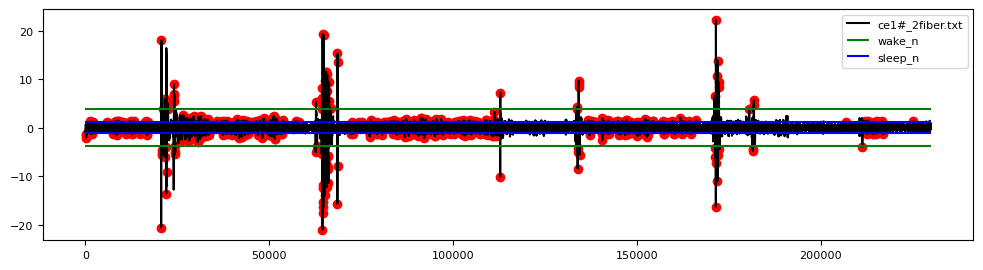

REM episode持续时间：[]
('rawdata\\mice1#\\fiber3\\mice1#_3fiber.txt', 'rawdata\\mice1#\\sleep3\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice1#\\sleep3\\modify_sleeprawdata.txt')


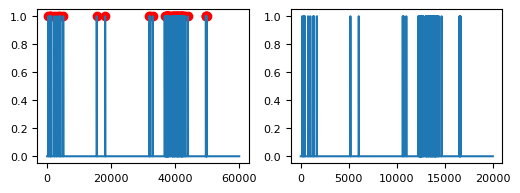

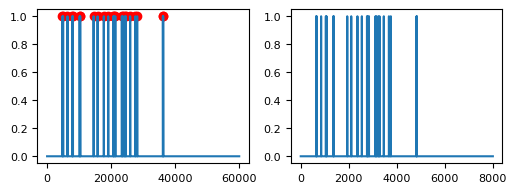

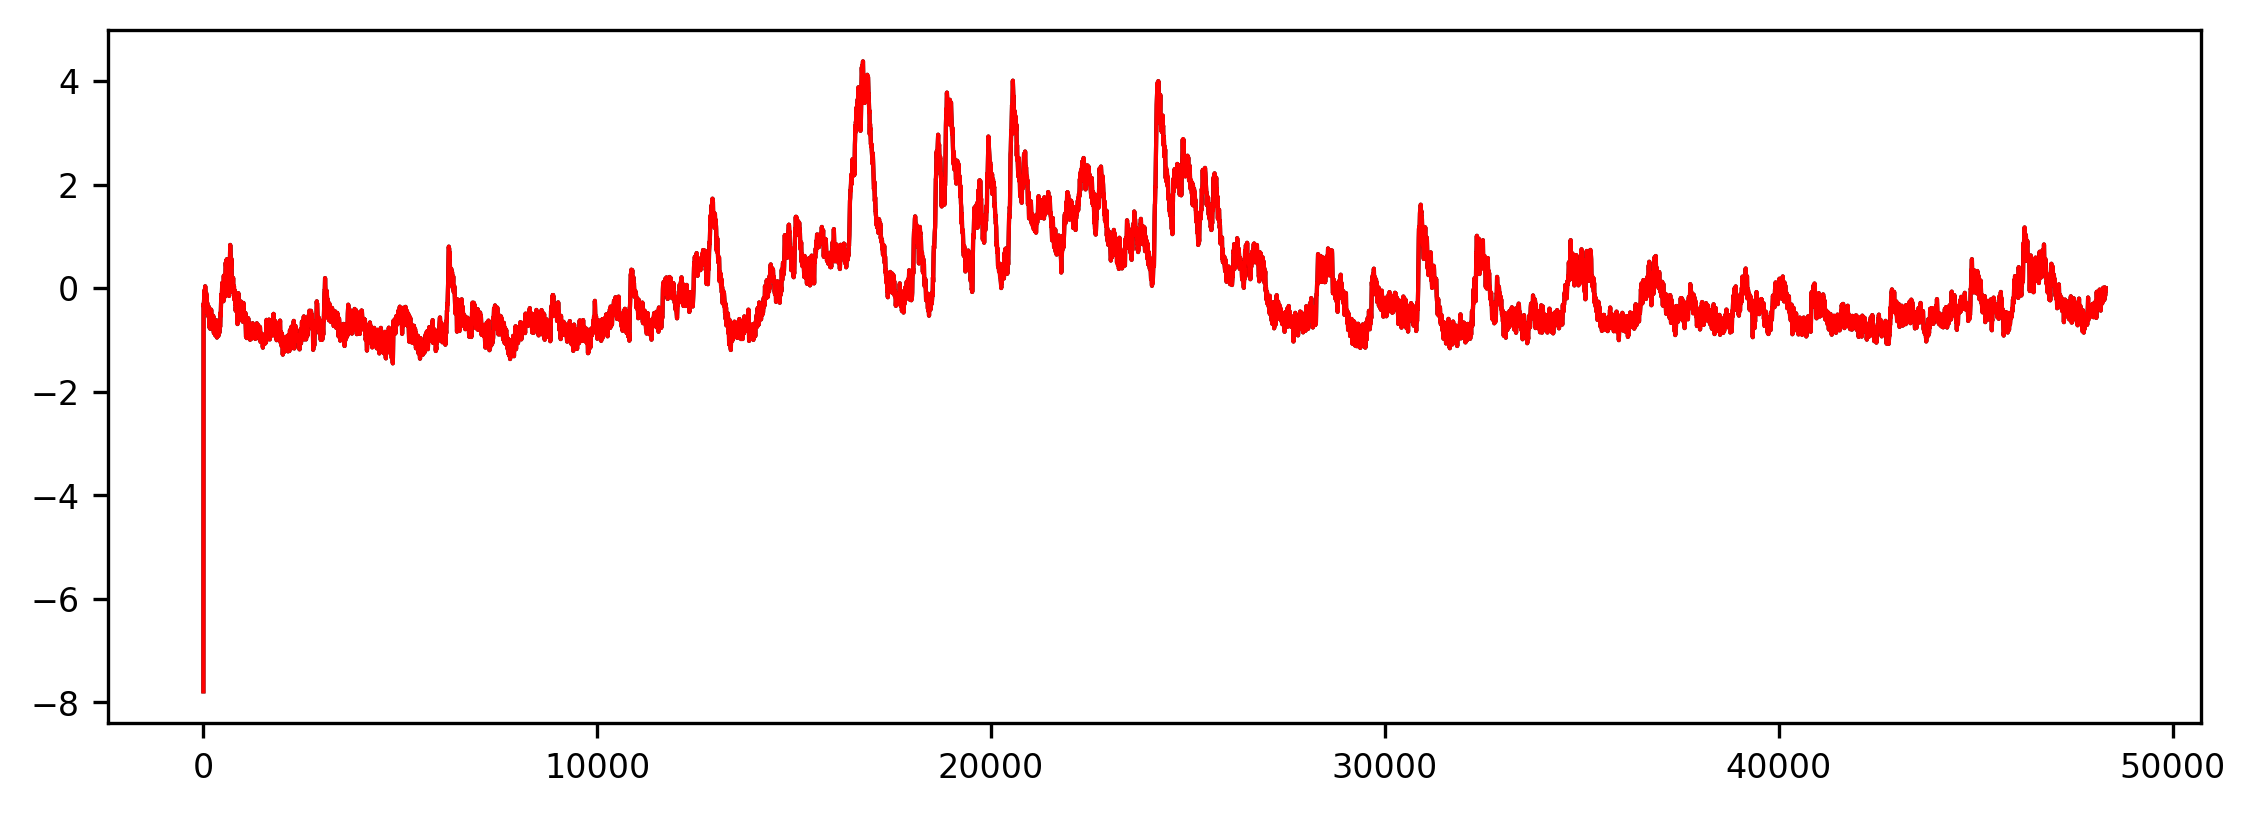

---计算每个epoch的眼动频率---
micece1#_3fiber.txtem_mean:{'0': 0.0029392994949494957, '5': -0.00020393084066471162, '10': -0.00020393084066471162}
em_std:{'0': 2.7338354927144137, '5': 0.7153602627276655, '10': 0.7153602627276655}


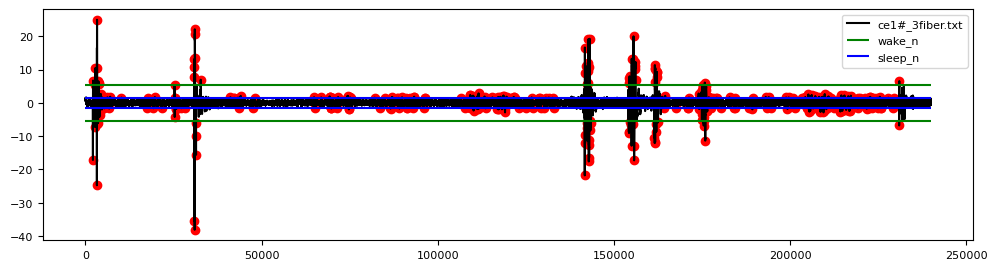

REM episode持续时间：[]
('rawdata\\mice2#\\fiber1\\mice2#_1fiber.txt', 'rawdata\\mice2#\\sleep1\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice2#\\sleep1\\modify_sleeprawdata.txt')


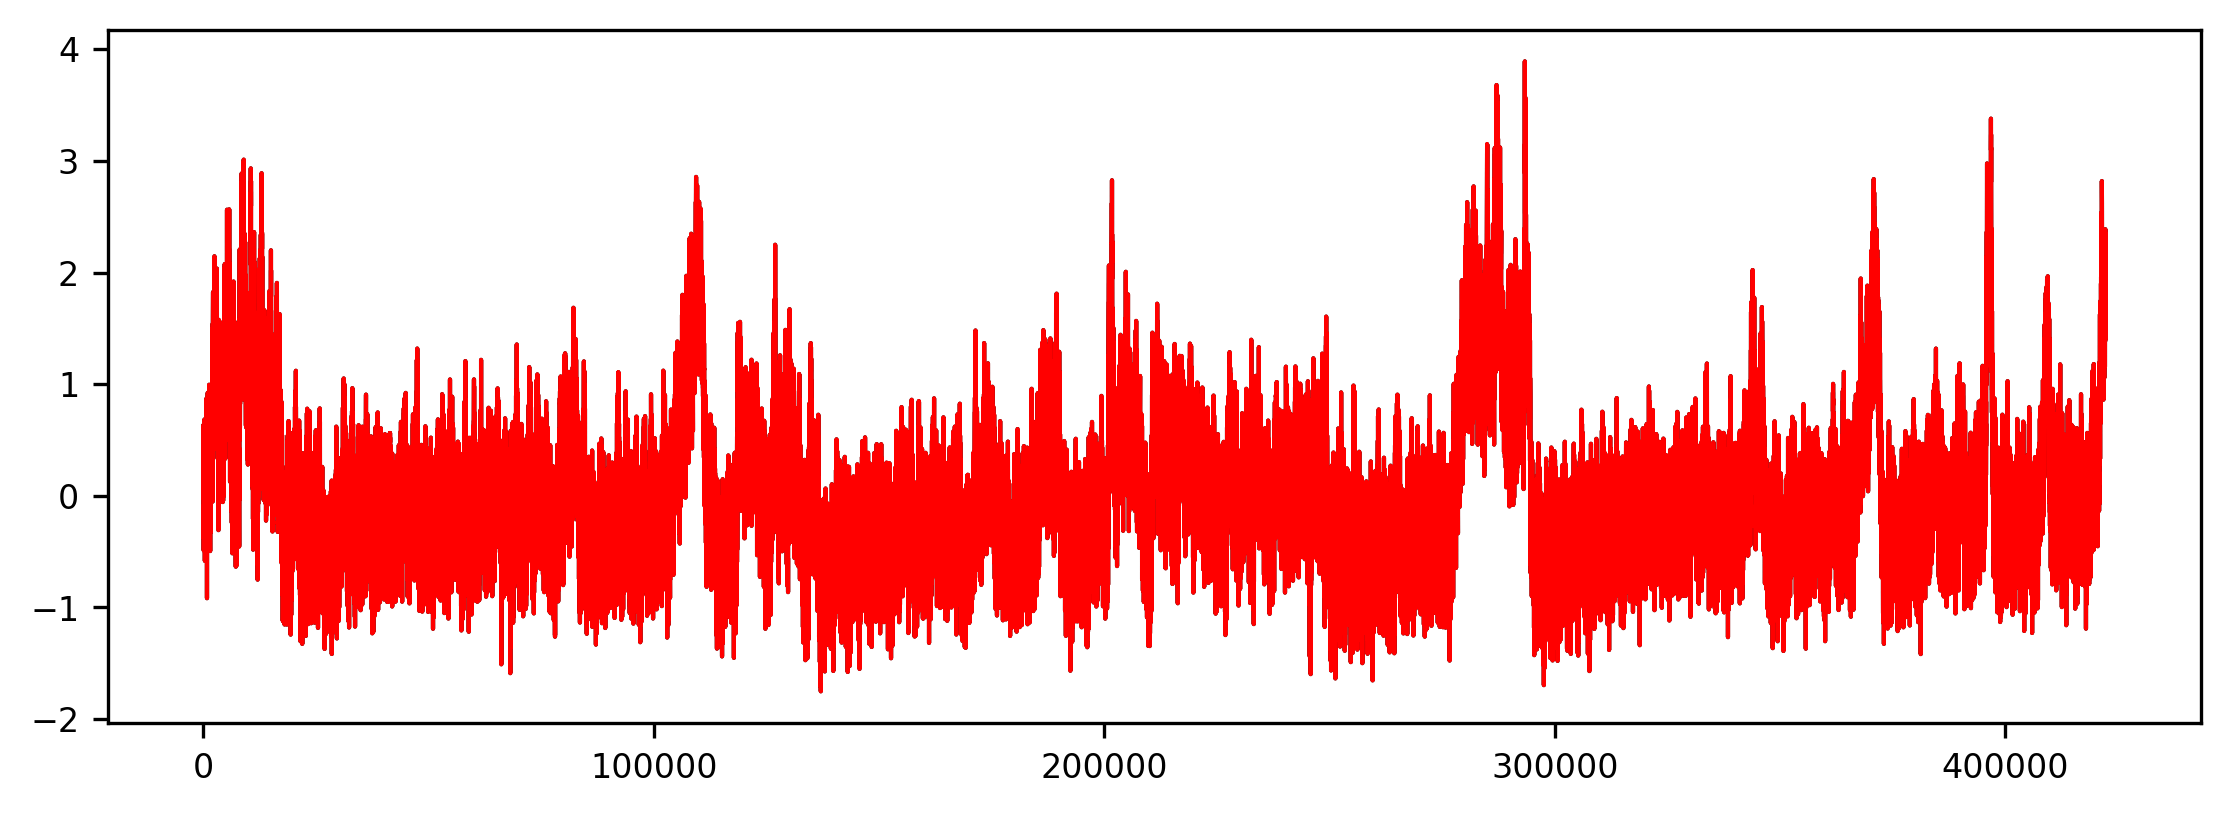

---计算每个epoch的眼动频率---
micece2#_1fiber.txtem_mean:{'0': -0.03359761950815129, '5': 0.008209240545955393, '10': 0.008209240545955393}
em_std:{'0': 353.03889923353836, '5': 81.23832759091552, '10': 81.23832759091552}


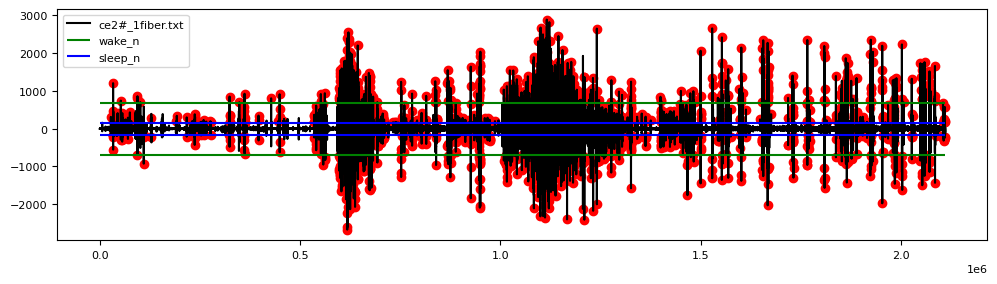

REM episode持续时间：[]
('rawdata\\mice2#\\fiber2\\mice2#_2fiber.txt', 'rawdata\\mice2#\\sleep2\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice2#\\sleep2\\modify_sleeprawdata.txt')


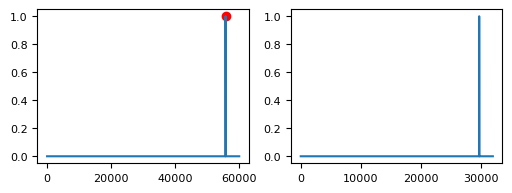

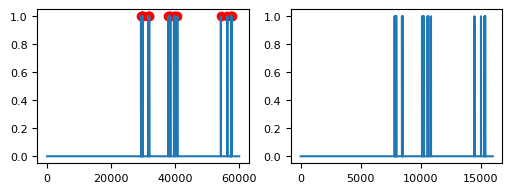

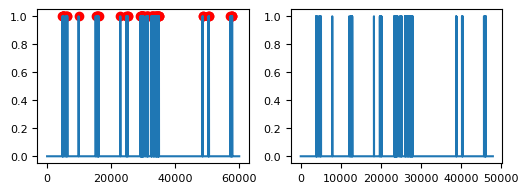

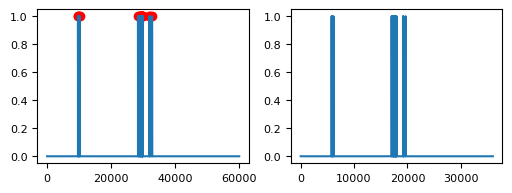

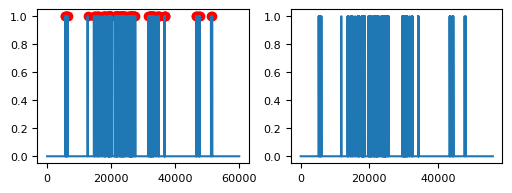

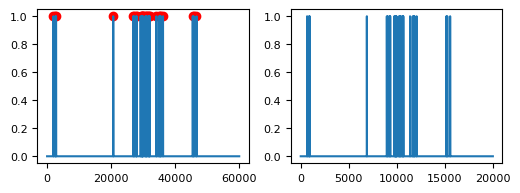

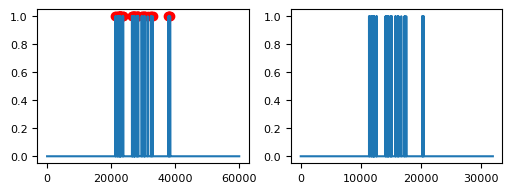

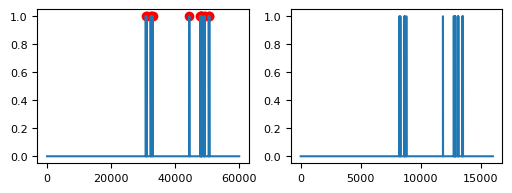

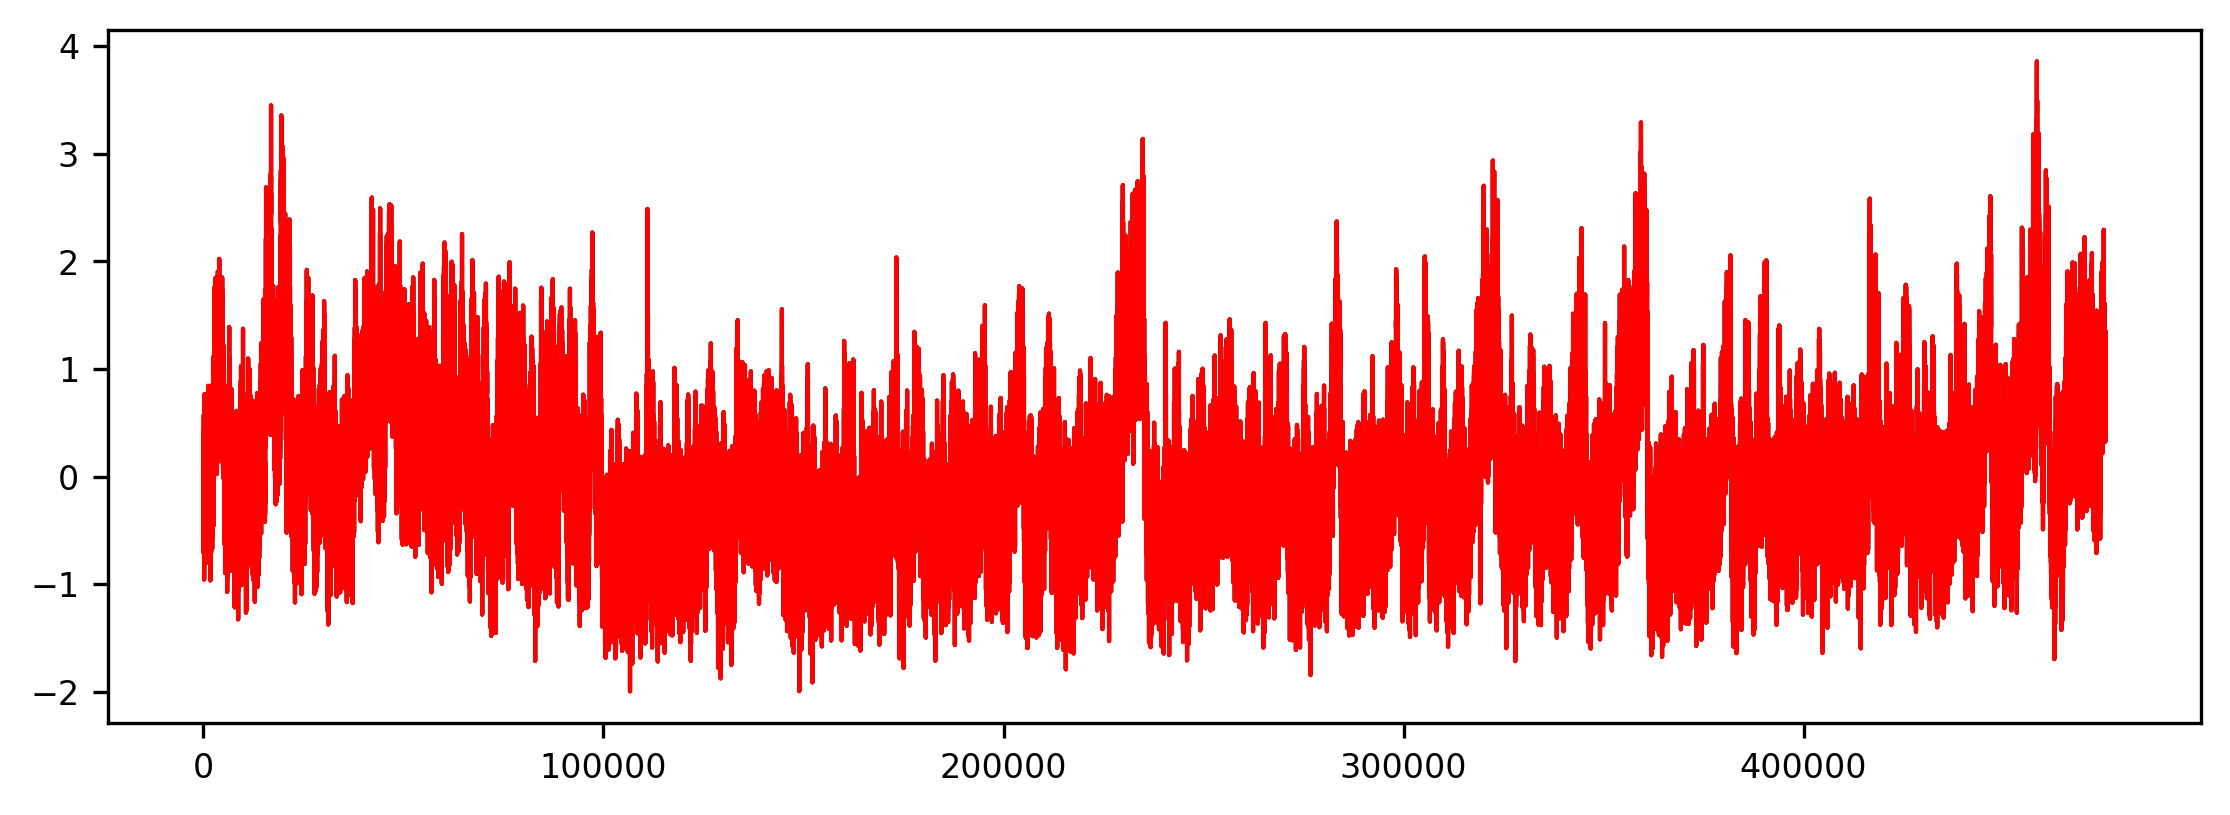

---计算每个epoch的眼动频率---
micece2#_2fiber.txtem_mean:{'0': -0.09576685370950924, '5': 0.056031533260895876, '10': 0.056031533260895876}
em_std:{'0': 328.30539467373364, '5': 106.34667405786942, '10': 106.34667405786942}


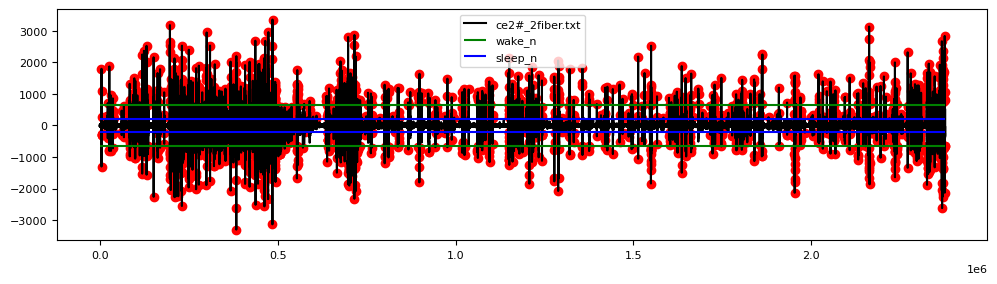

REM episode持续时间：[]


C:\Users\nVoke\AppData\Local\Temp\ipykernel_62288\817623648.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.subplots(1,2,figsize=(6,2))


('rawdata\\mice2#\\fiber3\\mice2#_3fiber.txt', 'rawdata\\mice2#\\sleep3\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice2#\\sleep3\\modify_sleeprawdata.txt')


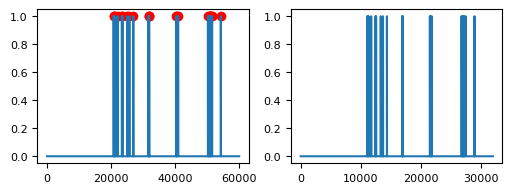

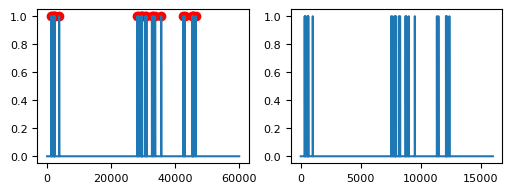

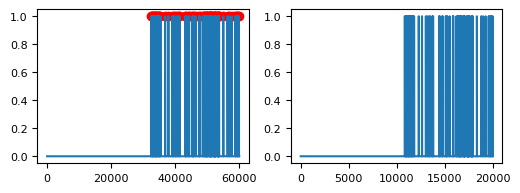

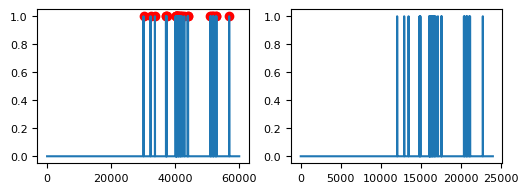

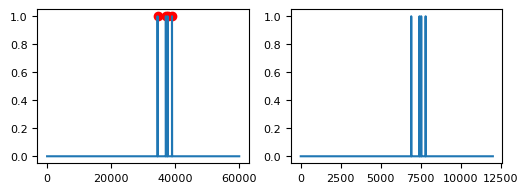

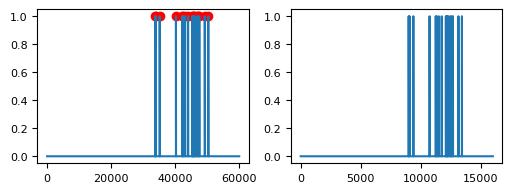

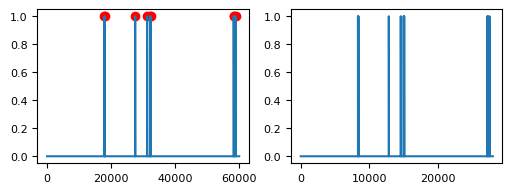

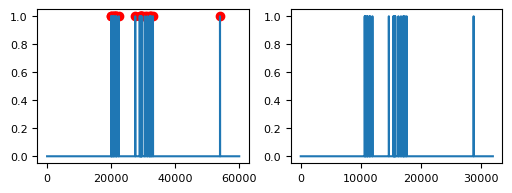

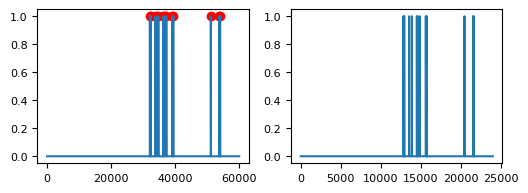

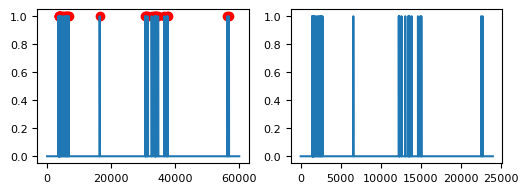

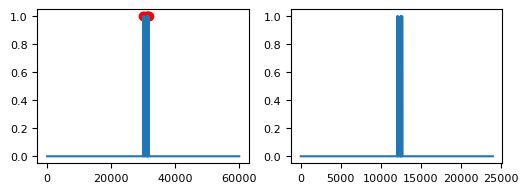

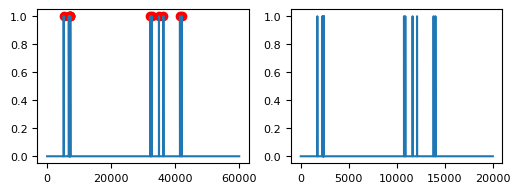

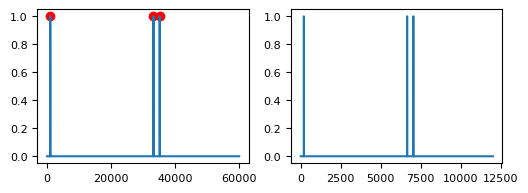

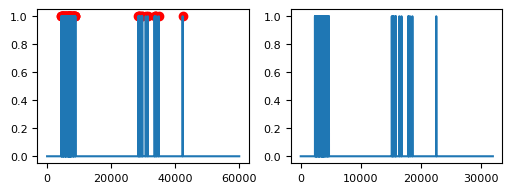

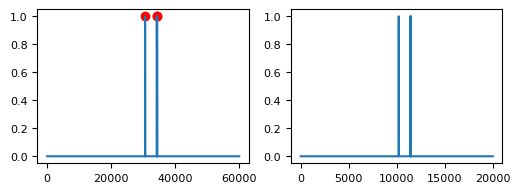

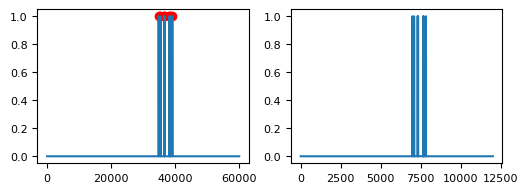

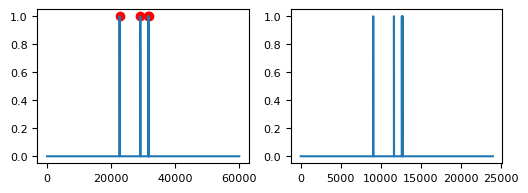

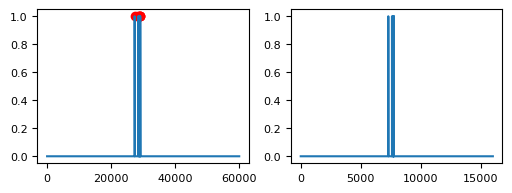

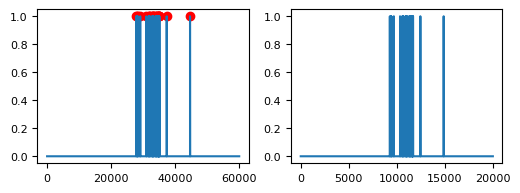

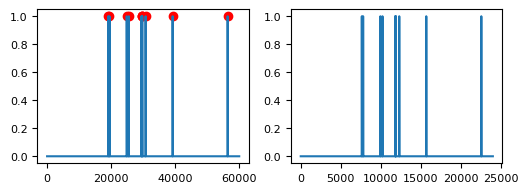

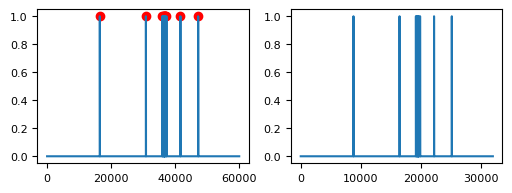

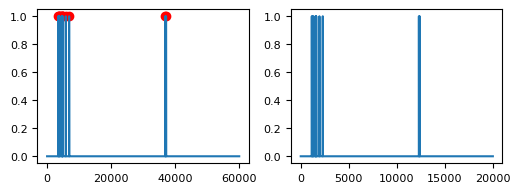

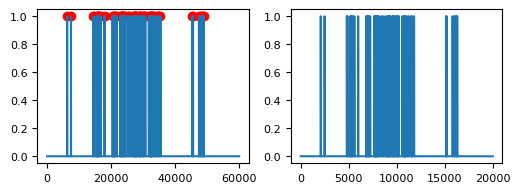

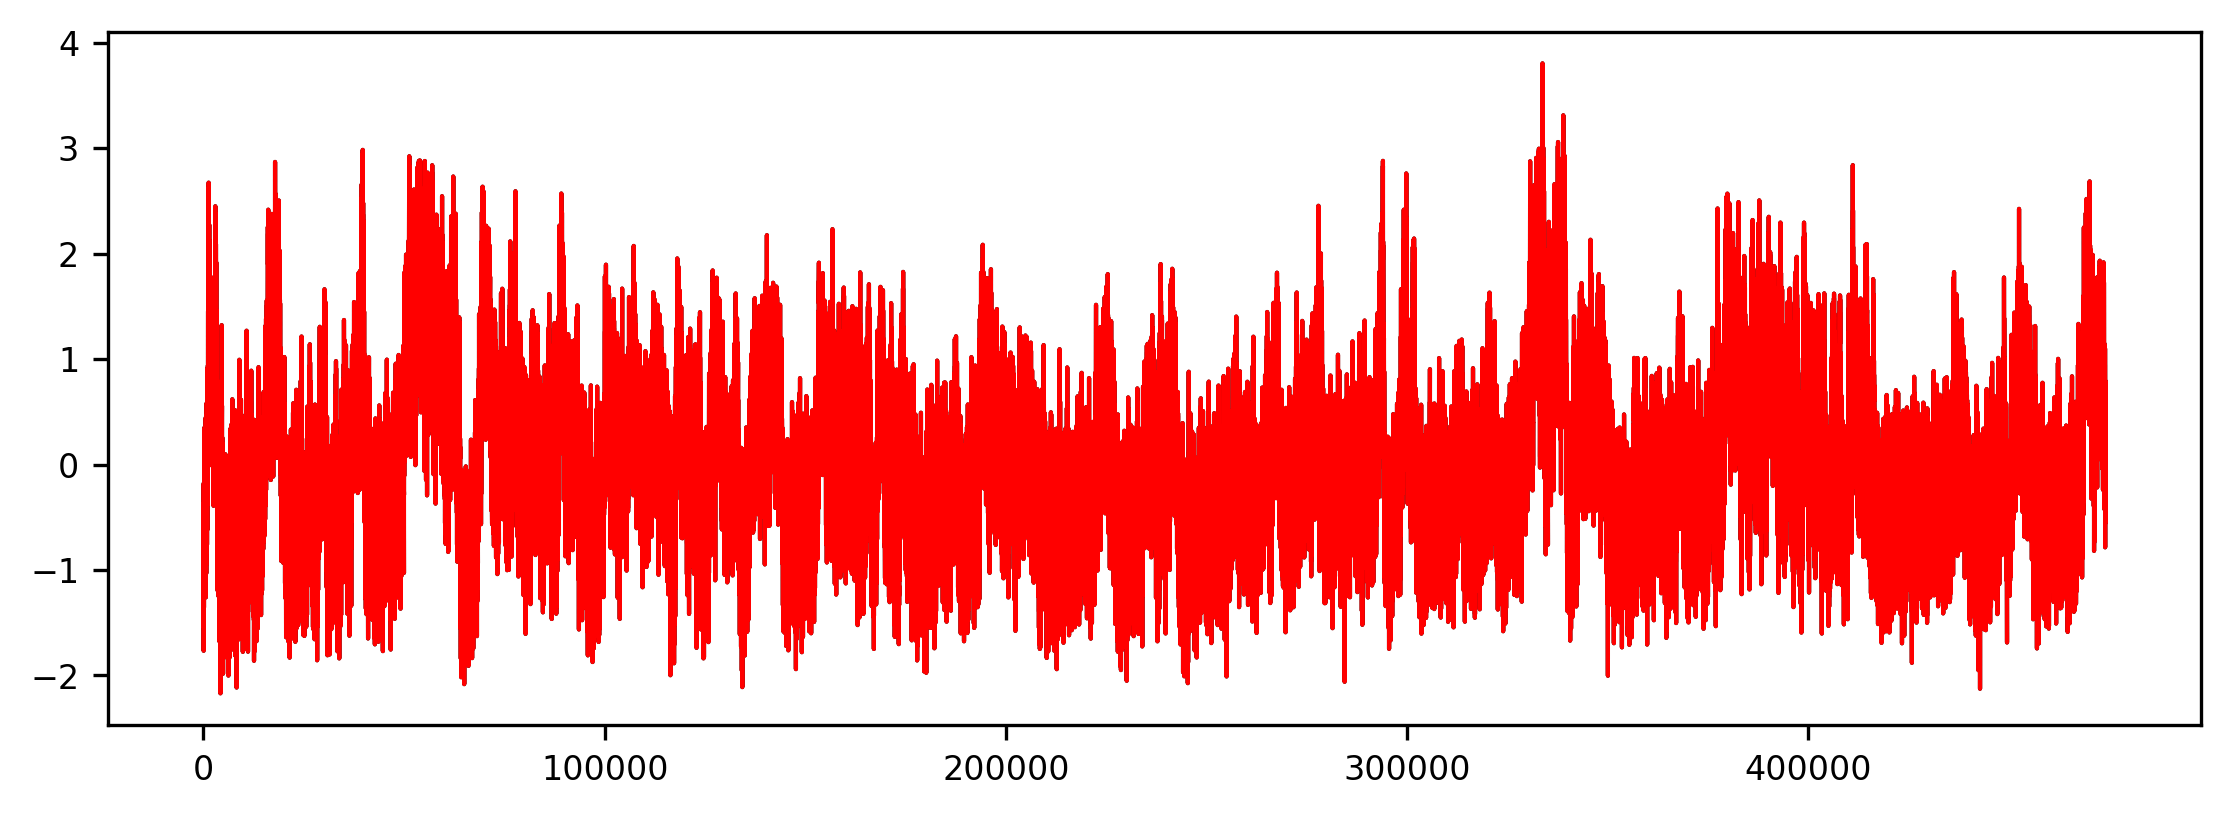

---计算每个epoch的眼动频率---
micece2#_3fiber.txtem_mean:{'0': 0.06174146296884977, '5': -0.09236421919027134, '10': -0.09236421919027134}
em_std:{'0': 397.0544352776542, '5': 94.53133713734361, '10': 94.53133713734361}


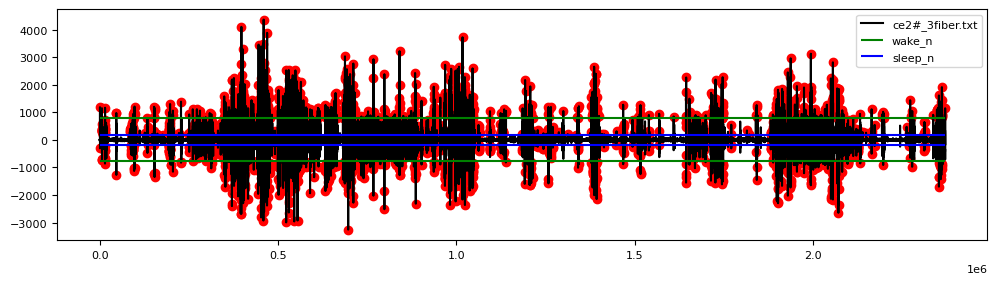

REM episode持续时间：[]
('rawdata\\mice4#\\fiber4\\mice4#_4fiber.txt', 'rawdata\\mice4#\\sleep4\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice4#\\sleep4\\modify_sleeprawdata.txt')


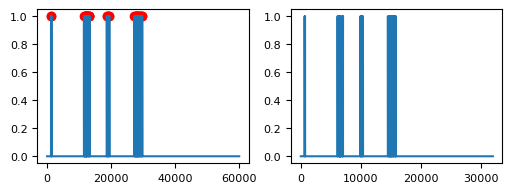

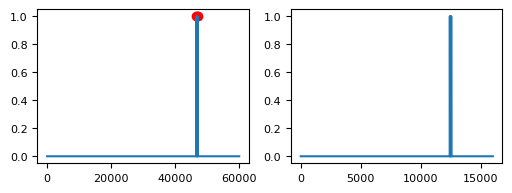

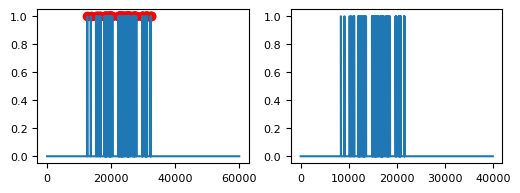

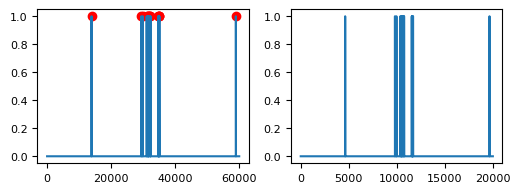

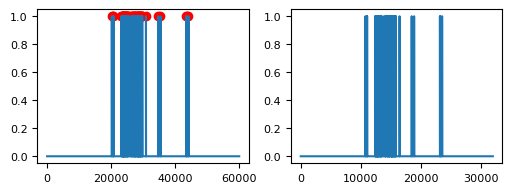

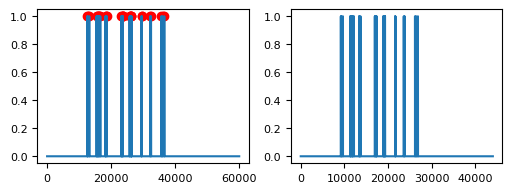

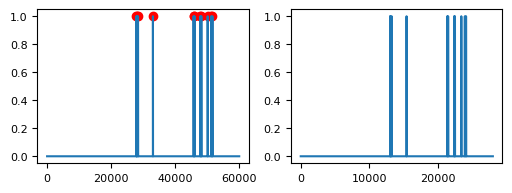

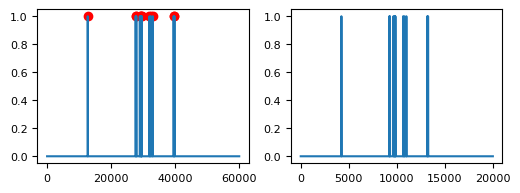

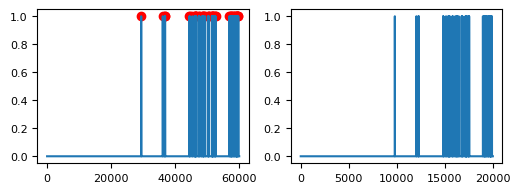

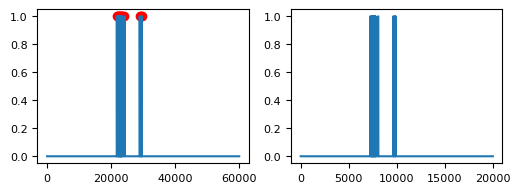

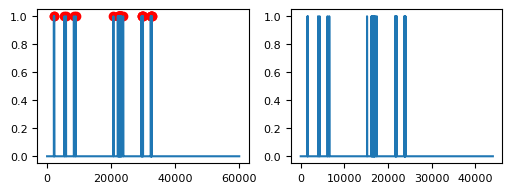

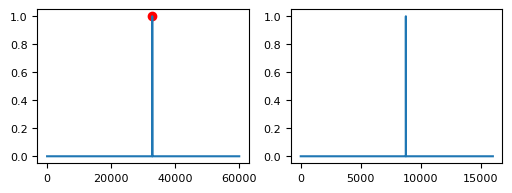

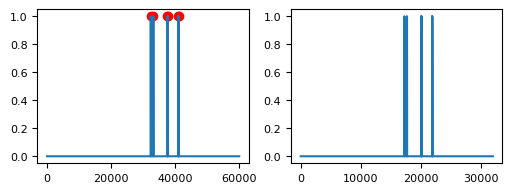

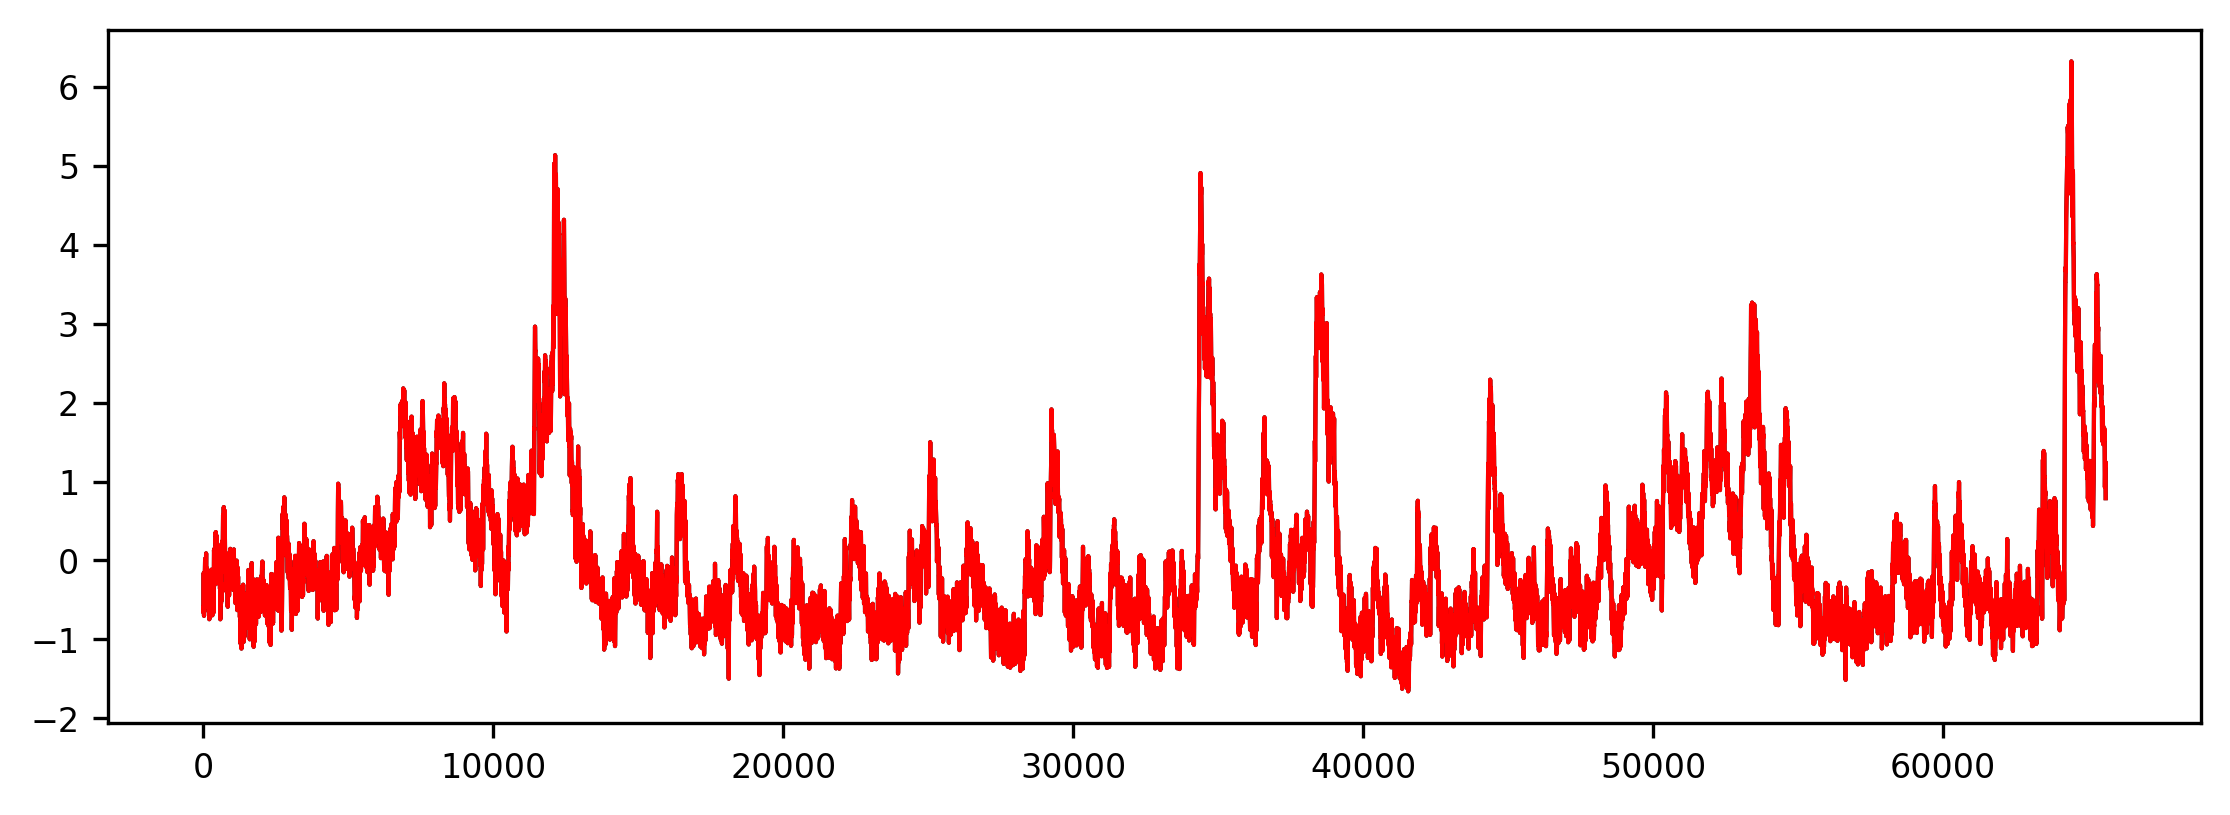

---计算每个epoch的眼动频率---
micece4#_4fiber.txtem_mean:{'0': -0.0009132829313543562, '5': -0.0004272980237154143, '10': -0.0004272980237154143}
em_std:{'0': 6.671905147300913, '5': 0.7321231053404557, '10': 0.7321231053404557}


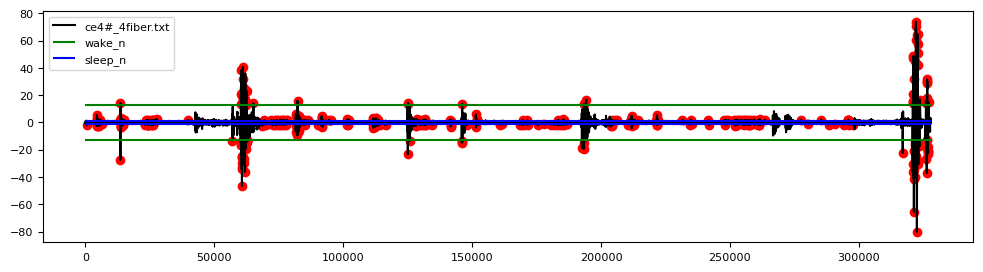

REM episode持续时间：[]
('rawdata\\mice4#\\fiber5\\mice4#_5fiber.txt', 'rawdata\\mice4#\\sleep5\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice4#\\sleep5\\modify_sleeprawdata.txt')


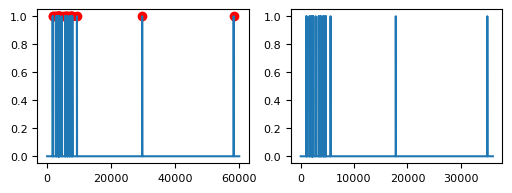

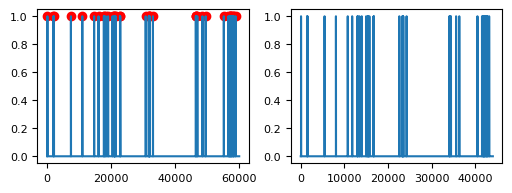

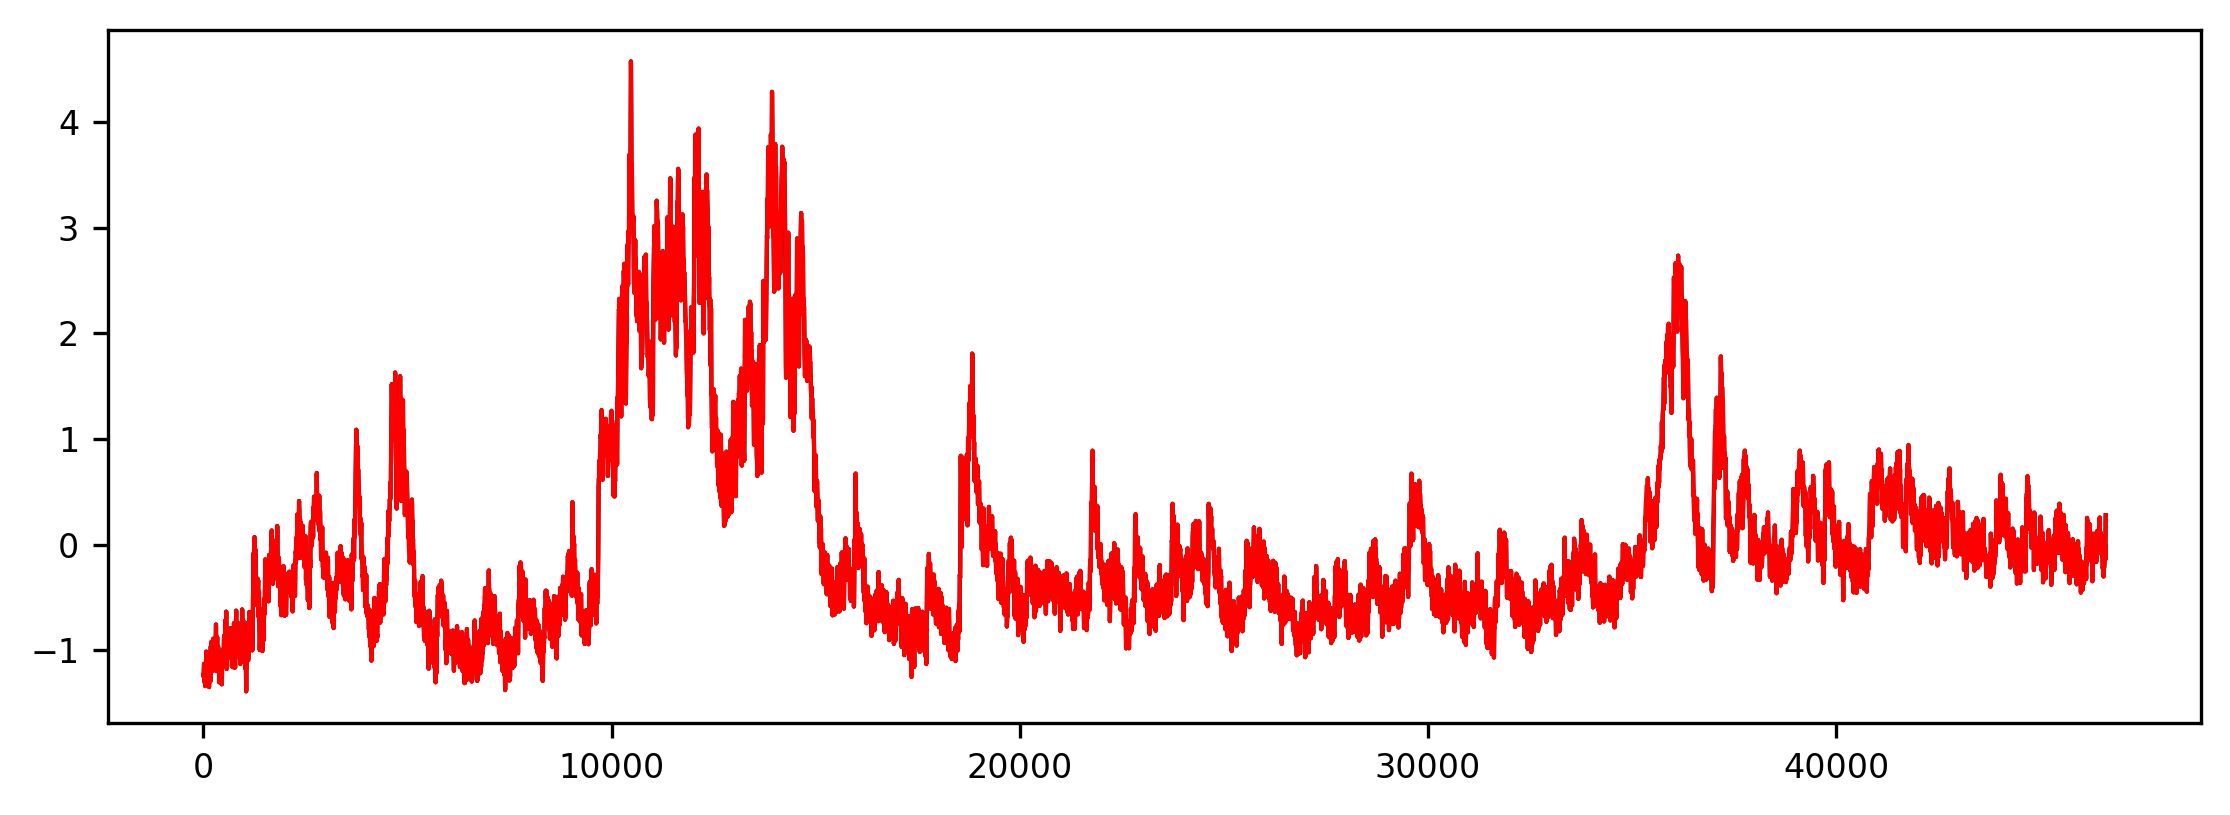

---计算每个epoch的眼动频率---
micece4#_5fiber.txtem_mean:{'0': 0.003471752228164036, '5': -0.002758458041958039, '10': -0.002758458041958039}
em_std:{'0': 12.596094936799421, '5': 0.8232454477590632, '10': 0.8232454477590632}


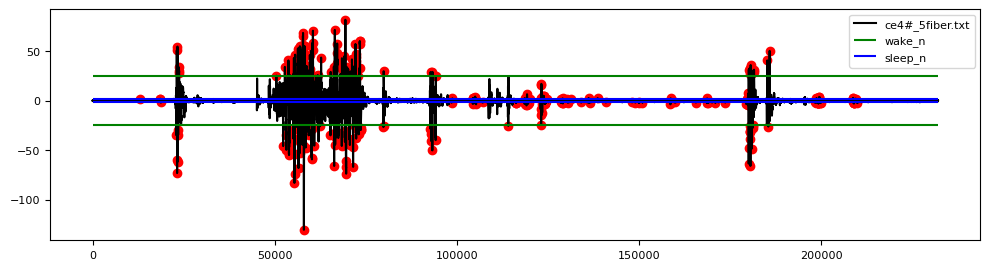

REM episode持续时间：[]
('rawdata\\mice4#\\fiber6\\mice4#_6fiber.txt', 'rawdata\\mice4#\\sleep6\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice4#\\sleep6\\modify_sleeprawdata.txt')


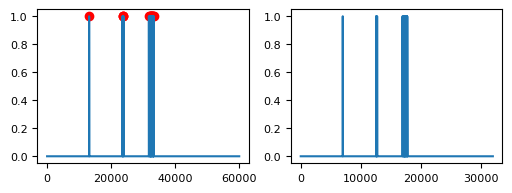

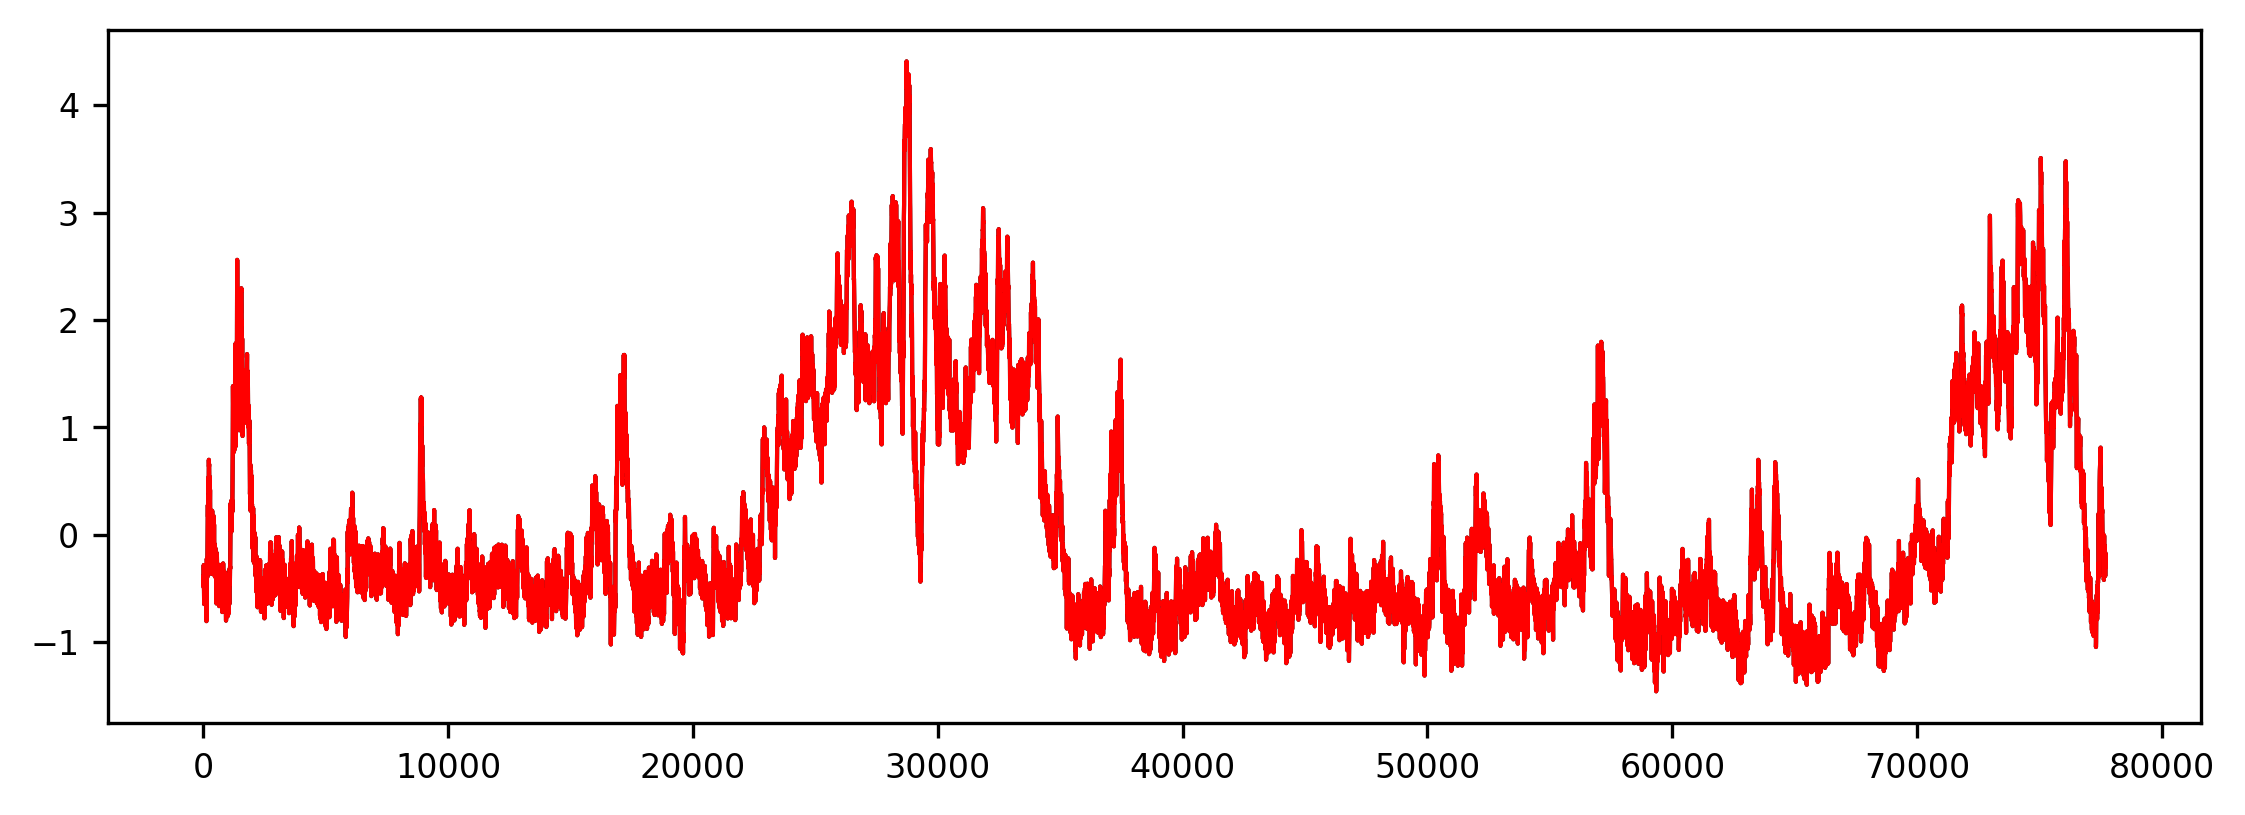

---计算每个epoch的眼动频率---
micece4#_6fiber.txtem_mean:{'0': -0.005061918181818167, '5': 0.0016644475084175092, '10': 0.0016644475084175092}
em_std:{'0': 5.831594884571319, '5': 0.6606280226400955, '10': 0.6606280226400955}


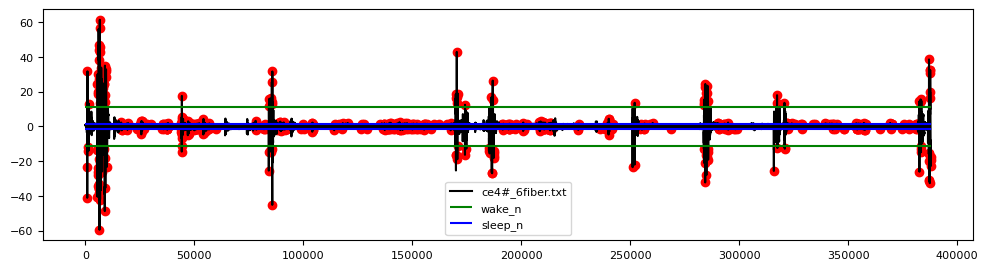

REM episode持续时间：[]
('rawdata\\mice5#\\fiber4\\mice5#_4fiber.txt', 'rawdata\\mice5#\\sleep4\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice5#\\sleep4\\modify_sleeprawdata.txt')


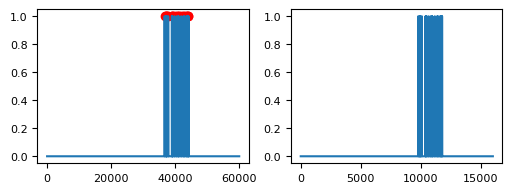

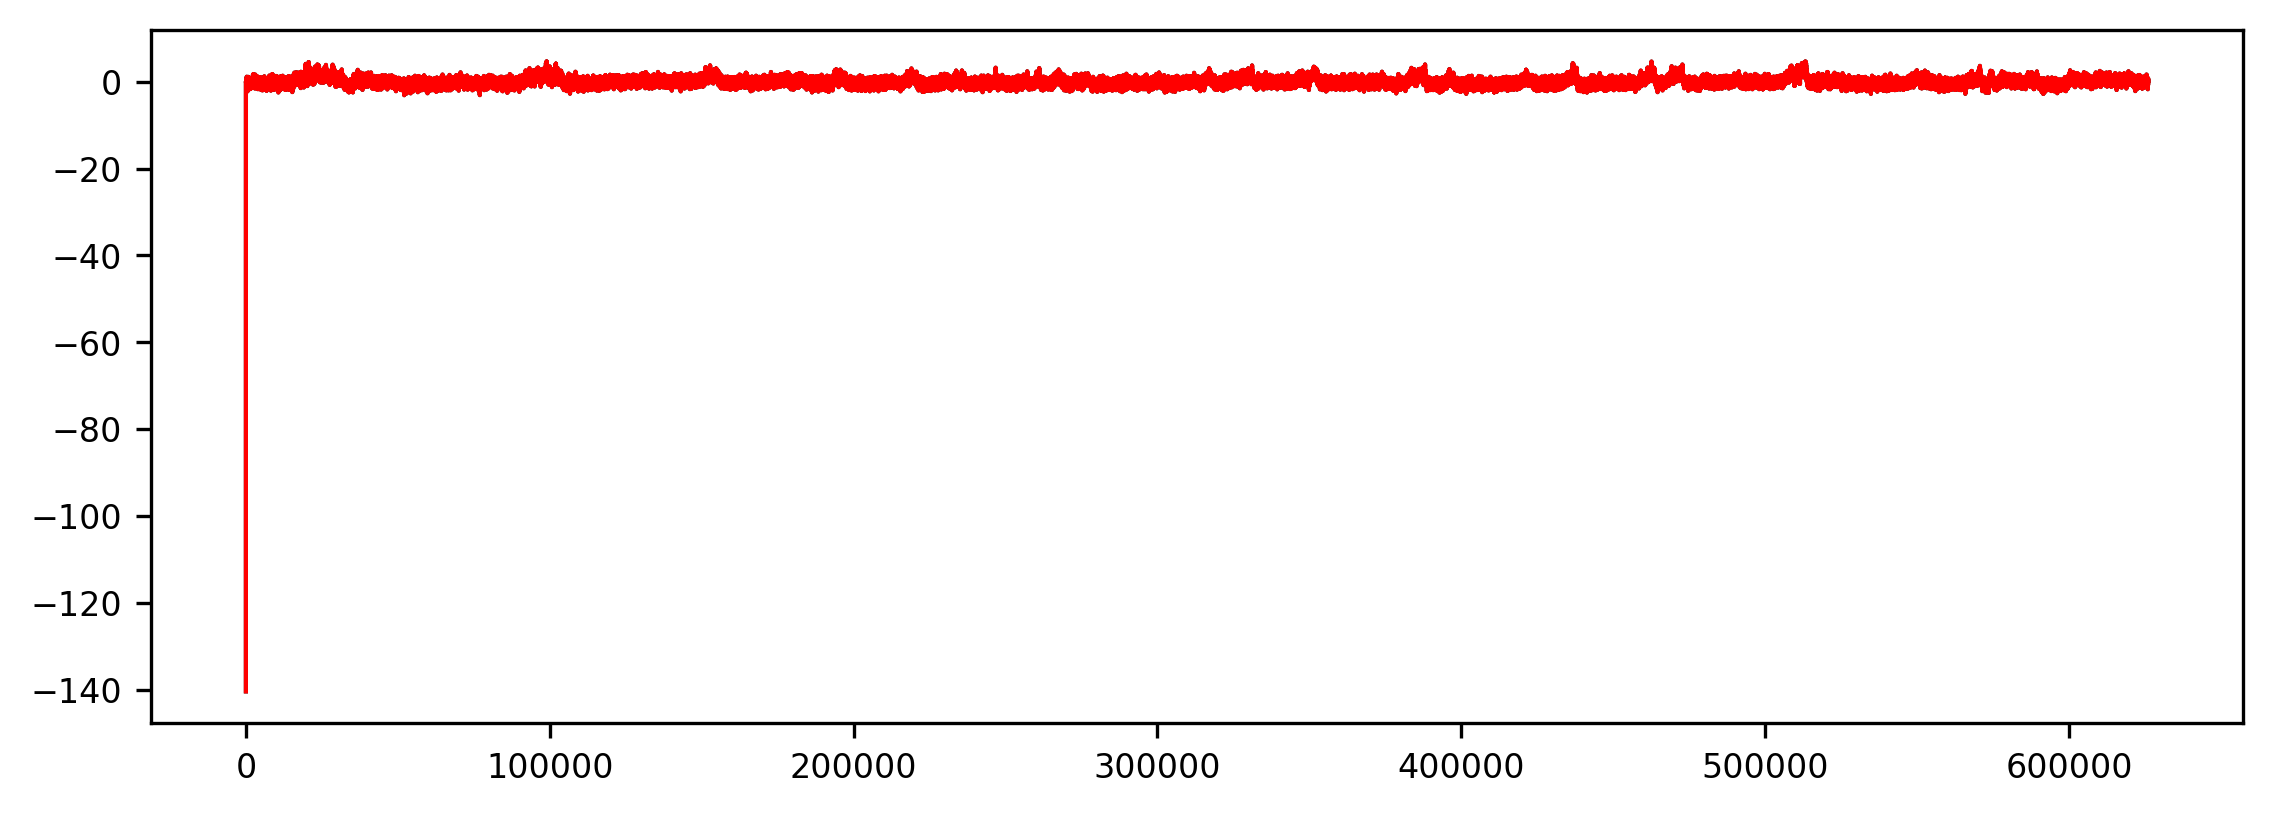

---计算每个epoch的眼动频率---
micece5#_4fiber.txtem_mean:{'0': 0.09467415157055, '5': -0.055128365513542506, '10': -0.055128365513542506}
em_std:{'0': 278.4209097512864, '5': 99.7763718348914, '10': 99.7763718348914}


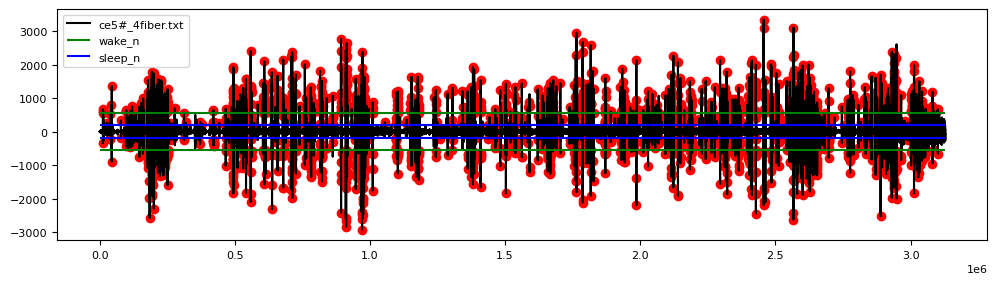

REM episode持续时间：[]
('rawdata\\mice5#\\fiber5\\mice5#_5fiber.txt', 'rawdata\\mice5#\\sleep5\\EEG_EMG_1_cFFT.txt', 'rawdata\\mice5#\\sleep5\\modify_sleeprawdata.txt')


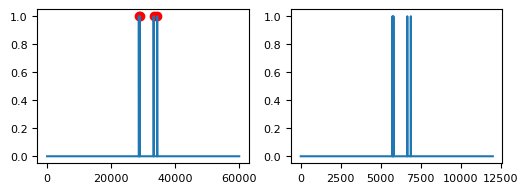

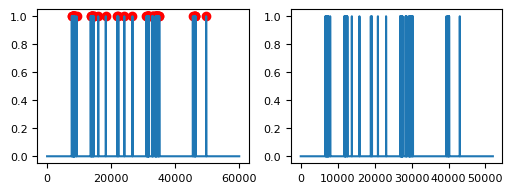

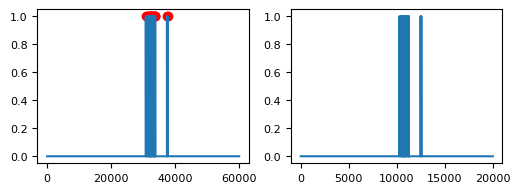

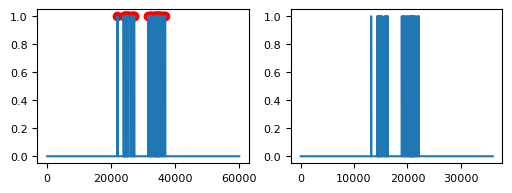

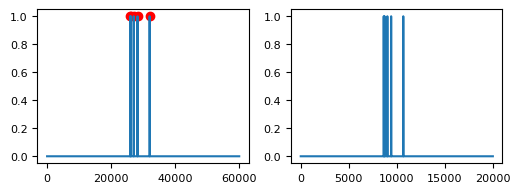

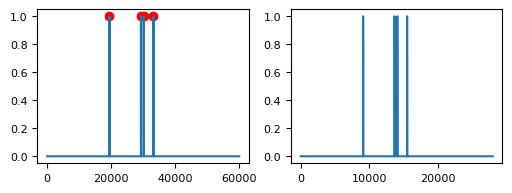

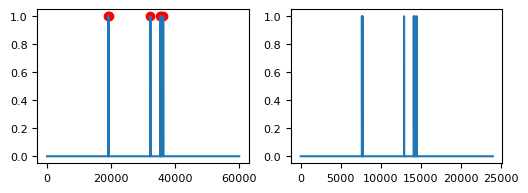

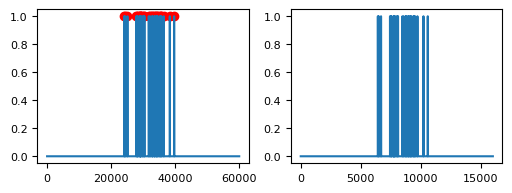

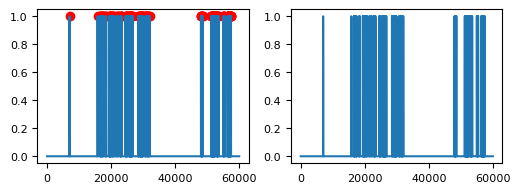

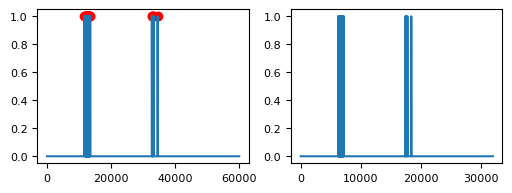

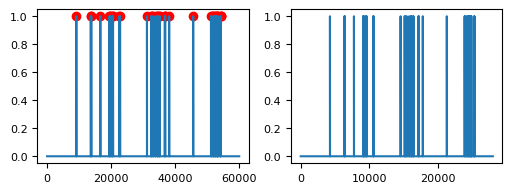

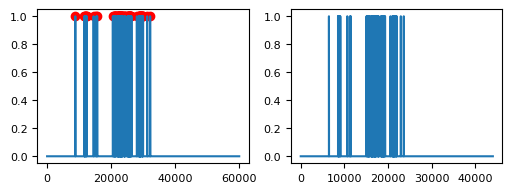

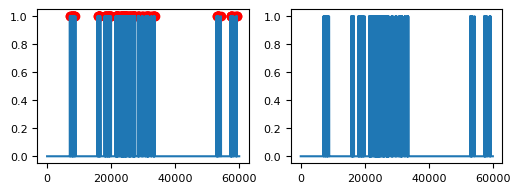

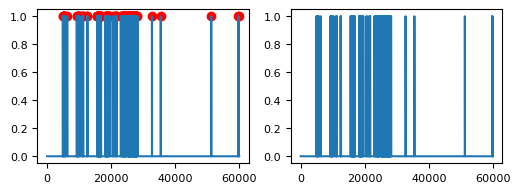

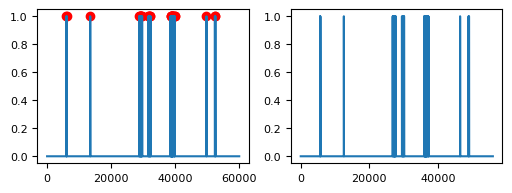

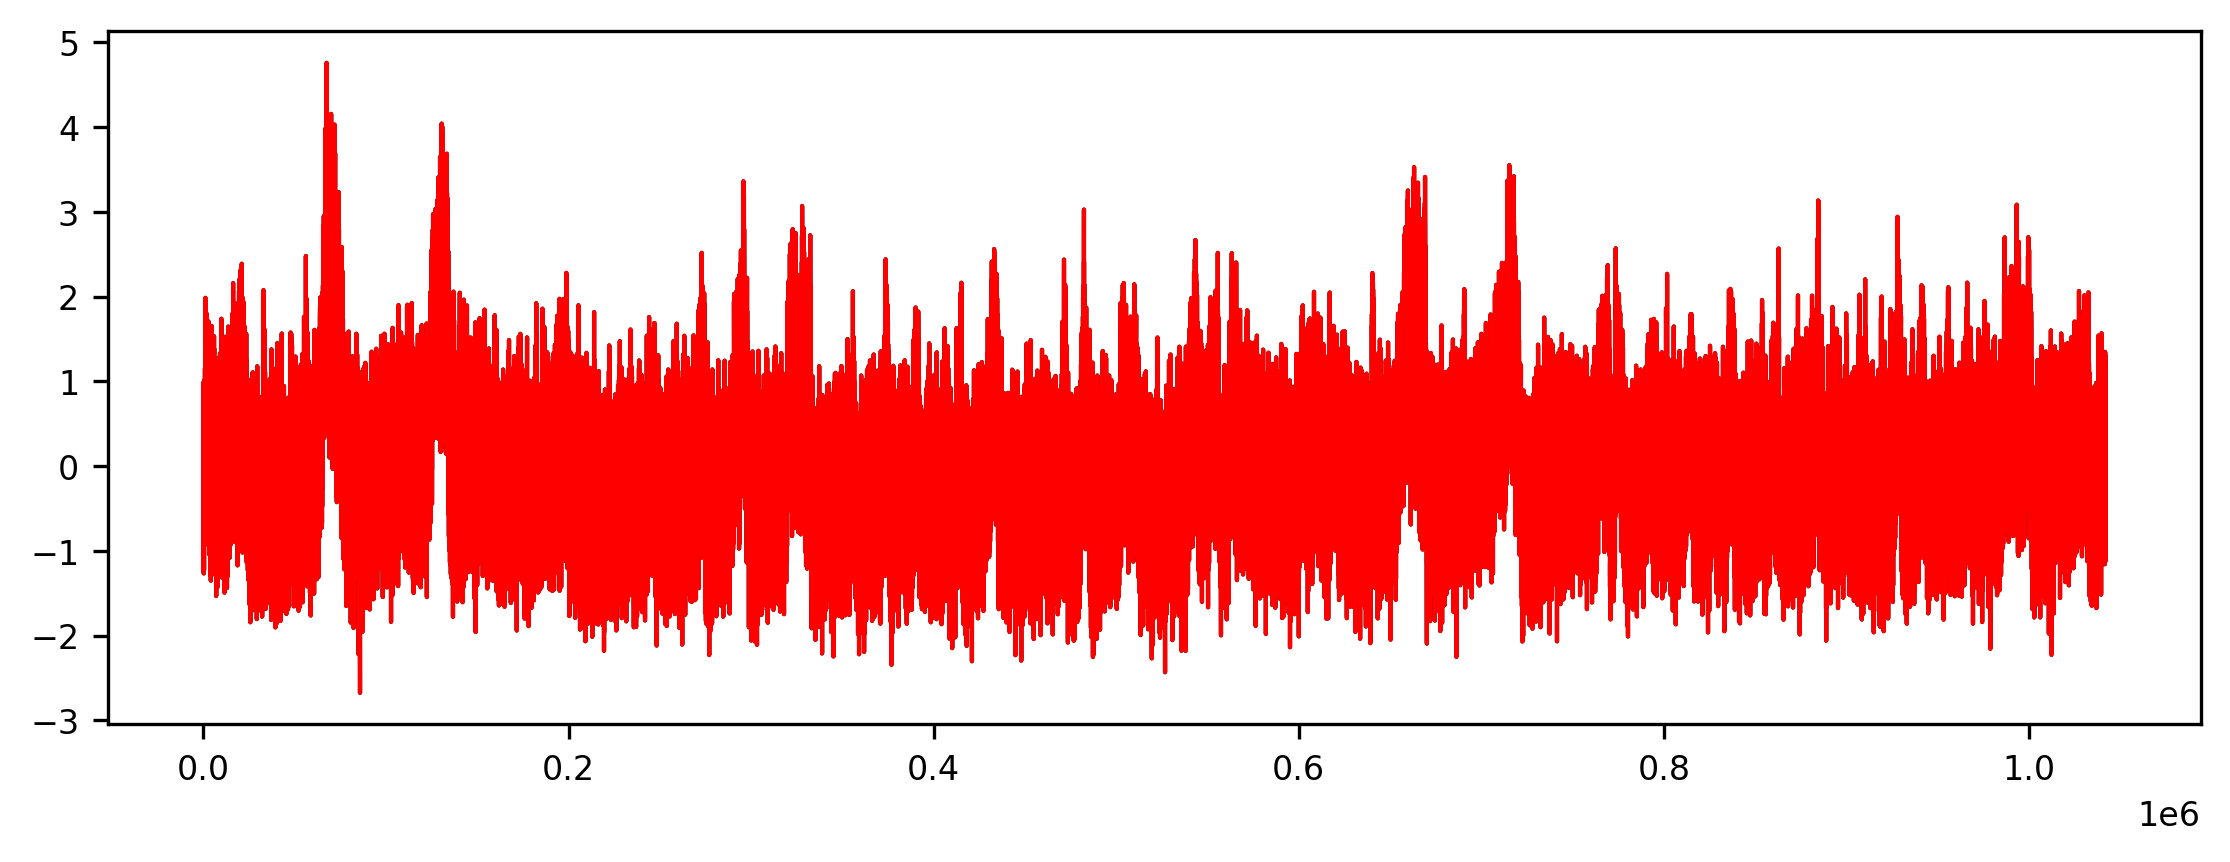

---计算每个epoch的眼动频率---
micece5#_5fiber.txtem_mean:{'0': -0.020097514679084893, '5': 0.010554977352659107, '10': 0.010554977352659107}
em_std:{'0': 271.92034746126427, '5': 84.3717594197954, '10': 84.3717594197954}


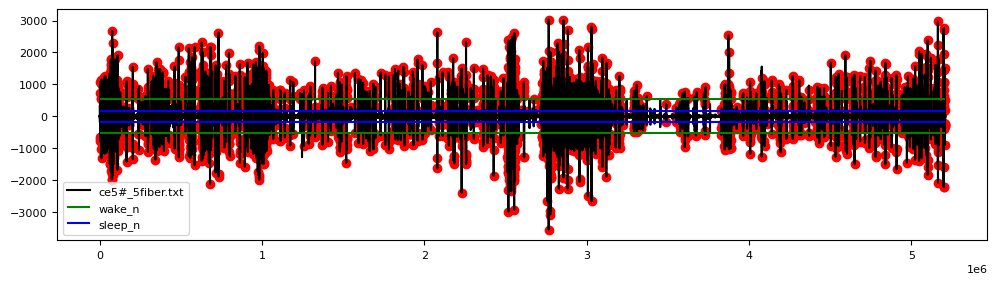

REM episode持续时间：[]


C:\Users\nVoke\AppData\Local\Temp\ipykernel_62288\817623648.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.subplots(1,2,figsize=(6,2))


trial数据结构(88, 60000)


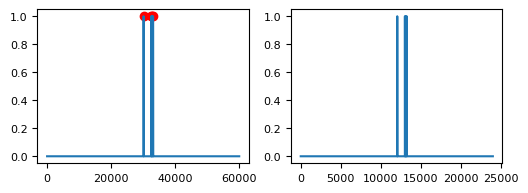

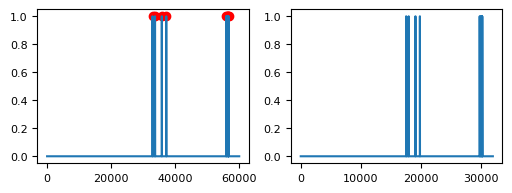

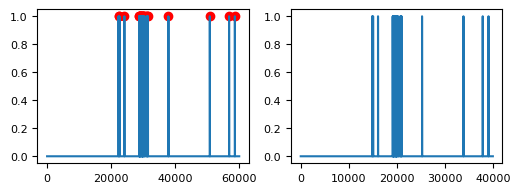

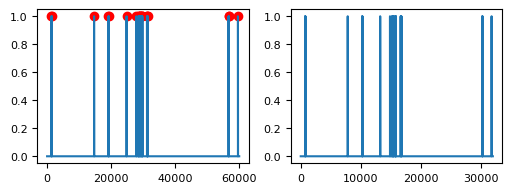

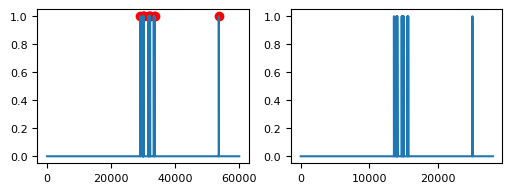

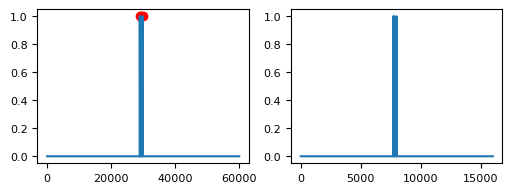

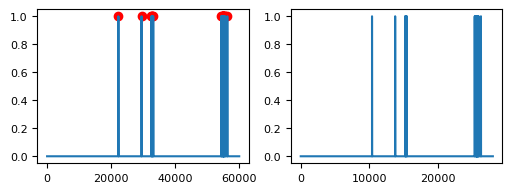

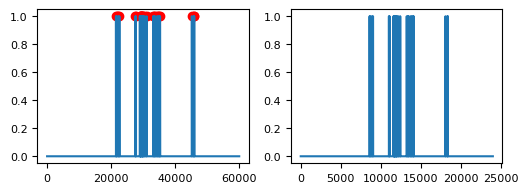

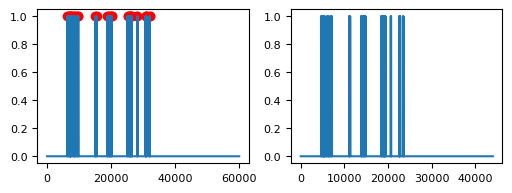

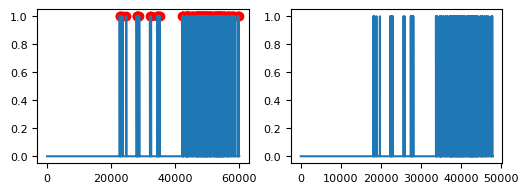

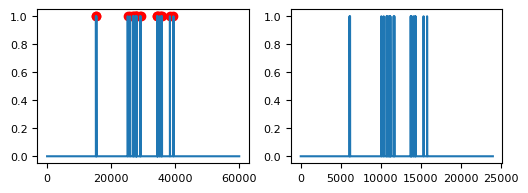

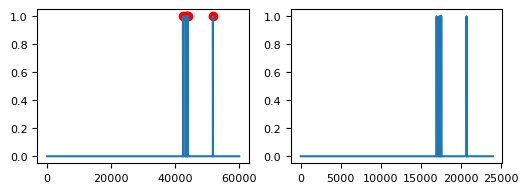

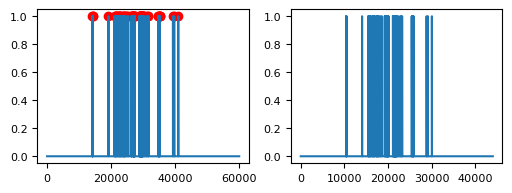

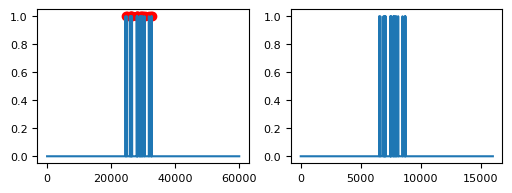

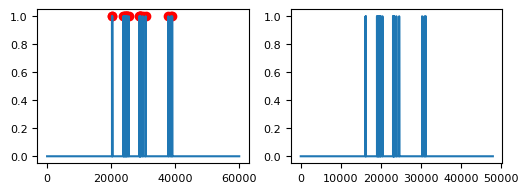

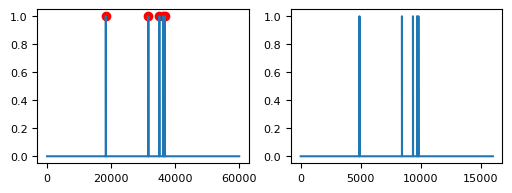

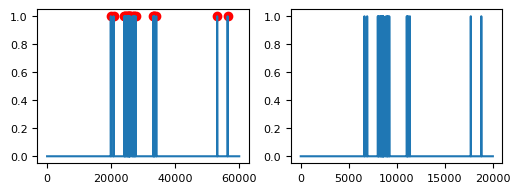

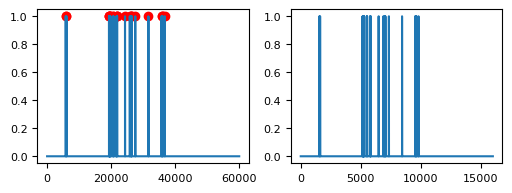

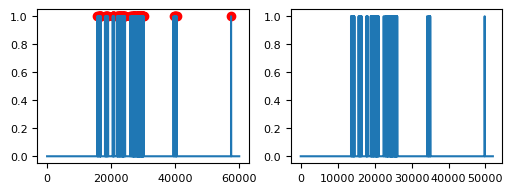

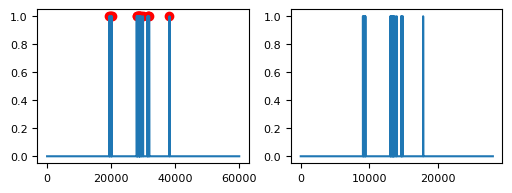

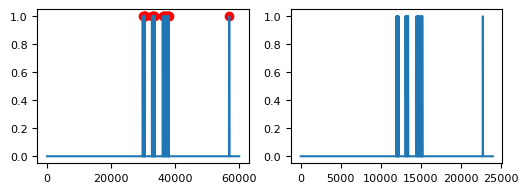

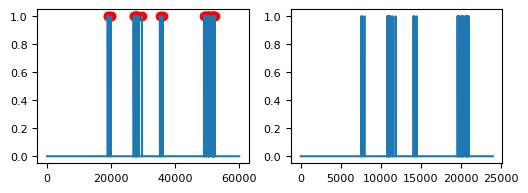

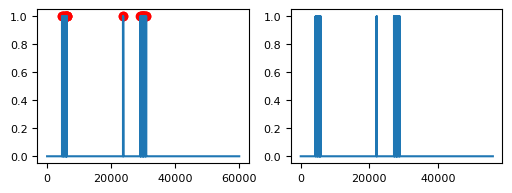

In [16]:
###用于处理fiberphotometry记录到的Ca信号在睡眠转变期间的变化以及对应的眼动，并对横轴进行normalization
if __name__ == '__main__':
    ###匹配同一个trial对应的睡眠和钙信号数据，并找到REM转变点对应的钙信号作图
    root_dir=r'.\rawdata'
    newPath=r'.\NREM-REMwithEMs'
    if not Path.exists(Path(newPath)):
        os.makedirs(newPath)

    is_save='yes'
    max_epoch=15                                                                                                                                                                                                                                               ####设置满足条件的刺激前的世间长度
    fre_em,fre_Ca=500,100
    file_info,mice_mean_bef,mice_mean_aft,mice_name=[],[],[],[]

    all_trial={'trial_name':[],'mean_em_before':[],'mean_em_after':[],'mean_Ca_before':[],'mean_Ca_after':[]}
    all_cell={'cell':[],'mean_before':[],'mean_after':[],'em':[]}

    mean_stage=[]
    root = Path(root_dir)
    file_info = scan_sort(root, file_info)
    df = pd.DataFrame(file_info, columns=['filename', 'ext', 'dir'])
# df.to_csv(root_dir+'\\'+'file_info.csv', index=False)
    trans_number=[]
    fiber_path,FFT_path,EM_path=[],[],[]
    for fname, dir in zip(df.filename, df.dir):
        path= os.path.join(dir, fname)
        if path.endswith('fiber.txt'):
            fiber_path.append(path)
        if path.endswith('cFFT.txt'):
            FFT_path.append(path)
        if path.endswith('modify_sleeprawdata.txt'):
            EM_path.append(path)
    fiber_sleep=[a for a in zip(fiber_path,FFT_path,EM_path)]
    pd.DataFrame(fiber_sleep).to_excel(os.path.dirname(newPath)+'\\文件目录.xlsx')
    for i in range(len(fiber_sleep)):
        print(fiber_sleep[i])
        fiber_mice(fiber_sleep[i])    ###可以做REM_off和t_pREM两种条件的钙信号数据

        # break

    print("trial数据结构{}".format(np.array(all_cell['cell']).shape))

    if np.array(all_cell['cell']).shape[0]==0:
        print('运行已结束：没有找到满足条件的数据')
        sys.exit(1)

In [17]:
    ###保存转变前后trial平均反应
    pd.DataFrame(all_trial).to_excel(newPath+'\\sumEM_and_meanCa.xlsx')

In [18]:
    ###统计REMtransition的REM持续时间
    a,b=np.unique(trans_number,return_counts=True)
    print(trans_number)
    if is_save=='yes':
        pd.DataFrame(trans_number).to_csv(newPath+'\\REM_duration_before_transition.txt')

[]


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


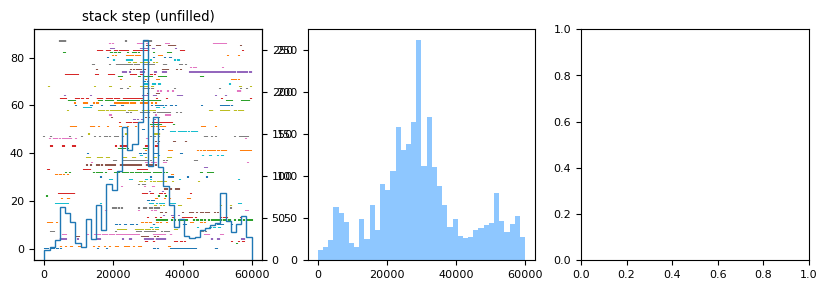

In [19]:
    ##将眼动二值化，转化为raster plot; The raster plot of the em activity
    em_index_arr=np.array(all_cell['em'])

    # print(em_index_arr.shape)
    # raster_tail=np.ones((em_index_arr.shape[0],1))
    # em_raster_new=np.concatenate((em_index_arr,raster_tail),axis=1)
    # em_raster_new=np.concatenate((raster_tail,em_raster_new),axis=1)
    em_raster=[]
    for i in em_index_arr:
        em_raster_i=[n[0] for n in enumerate(i) if n[1]==1]
        em_raster.append(em_raster_i)
    if is_save=='yes':
        np.save(newPath+'\\em_raster.npy',em_raster)
    ###如果已经保存作图数据，则直接运行一下代码即可，无需从头作图
    # root_dir=r'H:\EMdata\fiber photometry\OMNactivity_sleep\sleep_fiber\60s_normalized_time\REM-wake'
    # em_index_arr=np.load(root_dir+'\\em_raster.npy', allow_pickle=True)
    raster_plot(em_raster,len(em_index_arr),newPath)  ###defualt: dataset_type=list

In [20]:
    cell_map = sorted(np.array(all_cell['cell']), key=lambda x:np.mean(x), reverse=True)


    cell_map=[de_sampling(x,200) for x in cell_map]
    print(np.array(cell_map).shape)
    cell_map=np.array(cell_map)[:,1:]

(88, 300)


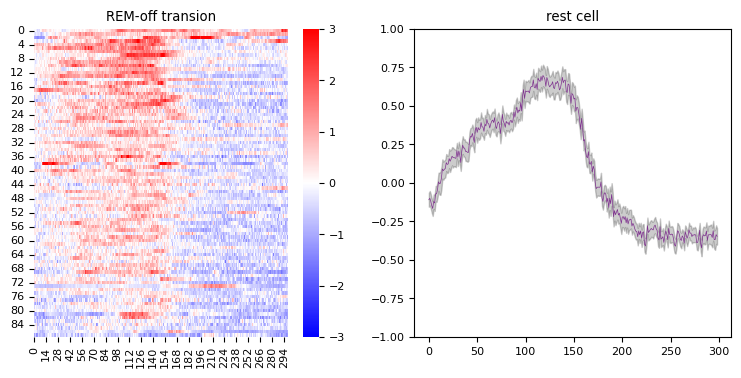

运行花费时间4.239105699999982


In [21]:
    start = time.perf_counter()

    mean_before=np.array(all_cell['mean_before'])
    mean_after=np.array(all_cell['mean_after'])
    # error_bar(mean_before,mean_after)

    df_bef_aft=pd.DataFrame(zip(mean_before,mean_after))
    df_bef_aft.columns=['cell_before','cell_after']
    # df_bef_aft.to_excel(out_path+'\\ave_bef_aft.xlsx')
    cell_map = sorted(np.array(all_cell['cell']), key=lambda x:np.mean(x), reverse=True)


    cell_map=[de_sampling(x,200) for x in cell_map]
    cell_map=np.array(cell_map)[:,1:]

    plt.figure(figsize=(9,4))
    plt.subplot(121);sns.heatmap(cell_map,vmax=3, vmin=-3, cmap='bwr');plt.title('REM-off transion')

    ave_cell=np.mean(cell_map,axis=0)
    # print(ave_cell)

    std_cell=np.std(cell_map,axis=0)/(math.sqrt(len(cell_map)))
    # print(std_cell)

    plt.subplot(122);plt.plot(ave_cell,linewidth=0.5,color='#7e318e');plt.title('rest cell')
    plt.subplot(122);plt.fill_between(range(len(ave_cell)),ave_cell-std_cell,ave_cell+std_cell,color='black', alpha=0.2, label='Ca2+_reaponse(Z-score)')
    plt.subplot(122);plt.ylim(-1,1)

    if is_save=='yes':
        np.save(newPath+'\\cell_map.npy',cell_map)
        # pd.DataFrame(cell_map).to_csv(newPath+'\\'+'cell_map.csv')
        plt.savefig(newPath+'\\'+'REM-wake_2.pdf',bbox_inches='tight')
    plt.show()

    end = time.perf_counter()
    print('运行花费时间{}'.format(end - start))